In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# DeepESN helper functions (same as provided, with np.int fixed)
def sparse_eye(M):
    dense_shape = (M, M)
    indices = np.zeros((M, 2))
    for i in range(M):
        indices[i, :] = [i, i]
    values = np.ones(shape=(M,)).astype('f')
    W = tf.sparse.reorder(tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape))
    return W

def sparse_tensor(M, N, C=1):
    dense_shape = (M, N)
    indices = np.zeros((M * C, 2))
    k = 0
    for i in range(M):
        idx = np.random.choice(N, size=C, replace=False)
        for j in range(C):
            indices[k, :] = [i, idx[j]]
            k += 1
    values = 2 * (2 * np.random.rand(M * C).astype('f') - 1)
    W = tf.sparse.reorder(tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape))
    return W

def sparse_recurrent_tensor(M, C=1):
    dense_shape = (M, M)
    indices = np.zeros((M * C, 2))
    k = 0
    for i in range(M):
        idx = np.random.choice(M, size=C, replace=False)
        for j in range(C):
            indices[k, :] = [idx[j], i]
            k += 1
    values = 2 * (2 * np.random.rand(M * C).astype('f') - 1)
    W = tf.sparse.reorder(tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape))
    return W

class ReservoirCell(keras.layers.Layer):
    def __init__(self, units, input_scaling=1., spectral_radius=0.99, leaky=1,
                 connectivity_input=10, connectivity_recurrent=10, **kwargs):
        self.units = units
        self.state_size = units
        self.input_scaling = input_scaling
        self.spectral_radius = spectral_radius
        self.leaky = leaky
        self.connectivity_input = connectivity_input
        self.connectivity_recurrent = connectivity_recurrent
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = sparse_tensor(input_shape[-1], self.units, self.connectivity_input) * self.input_scaling
        W = sparse_recurrent_tensor(self.units, C=self.connectivity_recurrent)
        if self.leaky == 1:
            e, _ = tf.linalg.eig(tf.sparse.to_dense(W))
            rho = max(abs(e))
            W = W * (self.spectral_radius / rho)
            self.recurrent_kernel = W
        else:
            I = sparse_eye(self.units)
            W2 = tf.sparse.add(I * (1 - self.leaky), W * self.leaky)
            e, _ = tf.linalg.eig(tf.sparse.to_dense(W2))
            rho = max(abs(e))
            W2 = W2 * (self.spectral_radius / rho)
            self.recurrent_kernel = tf.sparse.add(W2, I * (self.leaky - 1)) * (1 / self.leaky)
        self.bias = tf.random.uniform(shape=(self.units,), minval=-1, maxval=1) * self.input_scaling
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        input_part = tf.sparse.sparse_dense_matmul(inputs, self.kernel)
        state_part = tf.sparse.sparse_dense_matmul(prev_output, self.recurrent_kernel)
        output = prev_output * (1 - self.leaky) + tf.nn.tanh(input_part + self.bias + state_part) * self.leaky
        return output, [output]

class SimpleDeepReservoirLayer(keras.layers.Layer):
    def __init__(self, units=100, layers=1, concat=False,
                 input_scaling=1, inter_scaling=1,
                 spectral_radius=0.99, leaky=1,
                 connectivity_recurrent=10,
                 connectivity_input=10,
                 connectivity_inter=10,
                 return_sequences=False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layers = layers
        self.units = units
        if concat:
            units = int(units / layers)
        input_scaling_others = inter_scaling
        connectivity_input_1 = connectivity_input
        connectivity_input_others = connectivity_inter
        self.reservoir = [
            keras.layers.RNN(ReservoirCell(units=units,
                                           input_scaling=input_scaling,
                                           spectral_radius=spectral_radius,
                                           leaky=leaky,
                                           connectivity_input=connectivity_input_1,
                                           connectivity_recurrent=connectivity_recurrent),
                             return_sequences=True, return_state=True)
        ]
        for _ in range(layers - 1):
            self.reservoir.append(keras.layers.RNN(ReservoirCell(units=units,
                                                                 input_scaling=input_scaling_others,
                                                                 spectral_radius=spectral_radius,
                                                                 leaky=leaky,
                                                                 connectivity_input=connectivity_input_others,
                                                                 connectivity_recurrent=connectivity_recurrent),
                                                   return_sequences=True, return_state=True))
        self.concat = concat
        self.return_sequences = return_sequences

    def call(self, inputs):
        X = inputs
        states = []
        states_last = []
        for reservoir_index in range(len(self.reservoir)):
            reservoir_layer = self.reservoir[reservoir_index]
            if reservoir_index > 0:
                X = layer_states
            [layer_states, layer_states_last] = reservoir_layer(X)
            states.append(layer_states)
            states_last.append(layer_states_last)
        if self.concat:
            if self.return_sequences:
                return keras.layers.Concatenate()(states)
            else:
                return keras.layers.Concatenate()(states_last)
        else:
            if self.return_sequences:
                return states[-1]
            else:
                return states_last[-1]

# Pipeline parameters
K = 64
CP = K // 4
pilot_interval = 4
num_pilots = K // pilot_interval
mu = 4
SNRdb = 25
num_rx = 2
num_taps = 3
power_db = [0, -3, -6]
power_profile = 10 ** (np.array(power_db) / 10)
power_profile /= np.sum(power_profile)

# 16-QAM constellation
mapping_table = {
    (0,0,0,0): -3-3j, (0,0,0,1): -3-1j, (0,0,1,0): -3+3j, (0,0,1,1): -3+1j,
    (0,1,0,0): -1-3j, (0,1,0,1): -1-1j, (0,1,1,0): -1+3j, (0,1,1,1): -1+1j,
    (1,0,0,0):  3-3j, (1,0,0,1):  3-1j, (1,0,1,0):  3+3j, (1,0,1,1):  3+1j,
    (1,1,0,0):  1-3j, (1,1,0,1):  1-1j, (1,1,1,0):  1+3j, (1,1,1,1):  1+1j
}
constellation_raw = np.array(list(mapping_table.values()))
constellation = constellation_raw / np.sqrt(np.mean(np.abs(constellation_raw)**2))
pilot_symbol = constellation[0]
output_dim = 4 * 2  # H_sd0, H_sd1, H_comp0, H_comp1 (real and imag)
input_dim = output_dim + 1  # Add pilot indicator

# OFDM functions
def addCP(time_signal):
    cp = time_signal[-CP:]
    return np.hstack([cp, time_signal])

def removeCP(signal_withCP):
    return signal_withCP[CP:CP + K]

def generate_channel(num_taps, power_profile):
    h = np.sqrt(power_profile / 2) * (np.random.randn(num_taps) + 1j * np.random.randn(num_taps))
    return h

# Generate data sample with pilot indicator
def generate_data_sample():
    pilot_positions = np.arange(0, K, pilot_interval)
    data_positions = np.setdiff1d(np.arange(K), pilot_positions)
    S = np.zeros(K, dtype=complex)
    S[pilot_positions] = pilot_symbol
    symbol_indices_data = np.random.randint(0, len(constellation), len(data_positions))
    S[data_positions] = constellation[symbol_indices_data]
    OFDM_time = np.fft.ifft(S)
    OFDM_time /= np.sqrt(np.mean(np.abs(OFDM_time)**2))
    OFDM_withCP = addCP(OFDM_time)
    h_sr = generate_channel(num_taps, power_profile)
    h_sd = [generate_channel(num_taps, power_profile) for _ in range(num_rx)]
    h_rd = [generate_channel(num_taps, power_profile) for _ in range(num_rx)]
    H_sr = np.fft.fft(np.pad(h_sr, (0, K - num_taps)), n=K)
    H_sd = [np.fft.fft(np.pad(h, (0, K - num_taps)), n=K) for h in h_sd]
    H_rd = [np.fft.fft(np.pad(h, (0, K - num_taps)), n=K) for h in h_rd]
    H_comp = [H_sr * H_rdi for H_rdi in H_rd]
    noise_var = 10**(-SNRdb / 10)
    noise_std = np.sqrt(noise_var / 2)
    convolved_r = np.convolve(OFDM_withCP, h_sr)[:len(OFDM_withCP)]
    noise_r = noise_std * (np.random.randn(len(convolved_r)) + 1j * np.random.randn(len(convolved_r)))
    r_r = convolved_r + noise_r
    OFDM_demod_r = np.fft.fft(removeCP(r_r))
    OFDM_time_r = np.fft.ifft(OFDM_demod_r)
    OFDM_time_r /= np.sqrt(np.mean(np.abs(OFDM_time_r)**2))
    OFDM_withCP_r = addCP(OFDM_time_r)
    Y1 = []
    for i in range(num_rx):
        convolved_d1 = np.convolve(OFDM_withCP, h_sd[i])[:len(OFDM_withCP)]
        noise_d1 = noise_std * (np.random.randn(len(convolved_d1)) + 1j * np.random.randn(len(convolved_d1)))
        r_d1 = convolved_d1 + noise_d1
        Y1_i = np.fft.fft(removeCP(r_d1))
        Y1.append(Y1_i)
    Y2 = []
    for i in range(num_rx):
        convolved_d2 = np.convolve(OFDM_withCP_r, h_rd[i])[:len(OFDM_withCP_r)]
        noise_d2 = noise_std * (np.random.randn(len(convolved_d2)) + 1j * np.random.randn(len(convolved_d2)))
        r_d2 = convolved_d2 + noise_d2
        Y2_i = np.fft.fft(removeCP(r_d2))
        Y2.append(Y2_i)
    H1_est = [np.zeros(K, dtype=complex) for _ in range(num_rx)]
    H2_est = [np.zeros(K, dtype=complex) for _ in range(num_rx)]
    for k in pilot_positions:
        for i in range(num_rx):
            H1_est[i][k] = Y1[i][k] / pilot_symbol
            H2_est[i][k] = Y2[i][k] / pilot_symbol
    input_seq = np.zeros((K, input_dim))
    for k in range(K):
        vec = [
            H1_est[0][k].real, H1_est[0][k].imag,
            H1_est[1][k].real, H1_est[1][k].imag,
            H2_est[0][k].real, H2_est[0][k].imag,
            H2_est[1][k].real, H2_est[1][k].imag,
            1.0 if k in pilot_positions else 0.0  # Pilot indicator
        ]
        input_seq[k] = vec
    input_seq -= np.mean(input_seq, axis=0)
    input_seq /= (np.std(input_seq, axis=0) + 1e-8)
    labels = np.zeros((K, output_dim))
    for k in range(K):
        vec = [
            H_sd[0][k].real, H_sd[0][k].imag,
            H_sd[1][k].real, H_sd[1][k].imag,
            H_comp[0][k].real, H_comp[0][k].imag,
            H_comp[1][k].real, H_comp[1][k].imag
        ]
        labels[k] = vec
    return input_seq, labels, Y1, Y2, S, data_positions, H_sd, H_comp

# Generate dataset
def generate_dataset(num_samples):
    X = np.zeros((num_samples, K, input_dim))
    y = np.zeros((num_samples, K, output_dim))
    for i in range(num_samples):
        input_seq, labels, _, _, _, _, _, _ = generate_data_sample()
        X[i] = input_seq
        y[i] = labels
    return X, y

# Custom loss with smoothness regularization
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # Smoothness penalty: penalize large differences between adjacent subcarriers
    smoothness = tf.reduce_mean(tf.square(y_pred[:, 1:, :] - y_pred[:, :-1, :]))
    return mse + 0.01 * smoothness

# SimpleDeepESNRegressor with CNN
class SimpleDeepESNRegressor(keras.Model):
    def __init__(self, output_dim, units=100, layers=5,
                 concat=True,
                 spectral_radius=0.99, leaky=1,
                 input_scaling=1, inter_scaling=1,
                 connectivity_recurrent=10,
                 connectivity_input=10,
                 connectivity_inter=10,
                 return_sequences=False,
                 **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.masking = tf.keras.layers.Masking()
        self.conv = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.hidden = SimpleDeepReservoirLayer(units=units, layers=layers,
                                               concat=concat,
                                               spectral_radius=spectral_radius, leaky=leaky,
                                               input_scaling=input_scaling,
                                               inter_scaling=inter_scaling,
                                               connectivity_recurrent=connectivity_recurrent,
                                               connectivity_input=connectivity_input,
                                               connectivity_inter=connectivity_inter,
                                               return_sequences=return_sequences)
        self.output_ = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        m = self.masking(inputs)
        c = self.conv(m)
        h = self.hidden(c)
        y = self.output_(h)
        return y

# Generate data
num_train = 10000
num_test = 1000
X_train, y_train = generate_dataset(num_train)
X_test, y_test = generate_dataset(num_test)

# Model
model = SimpleDeepESNRegressor(output_dim=output_dim, units=600, layers=6, concat=True,
                               spectral_radius=0.9, leaky=0.3, input_scaling=1.2, inter_scaling=1.2,
                               connectivity_recurrent=30, connectivity_input=15, connectivity_inter=15,
                               return_sequences=True)

# Compile and train
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=custom_loss, metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE + Smoothness): {loss}, Test MAE: {mae}")

# Example prediction and SER with smoothing
def smooth_channel(H, alpha=0.3):
    # Exponential moving average smoothing
    H_smooth = np.copy(H)
    for k in range(1, len(H)):
        H_smooth[k] = alpha * H[k] + (1 - alpha) * H_smooth[k-1]
    return H_smooth

input_seq, true_labels, Y1, Y2, true_S, data_positions, true_H_sd, true_H_comp = generate_data_sample()
pred_H = model.predict(np.expand_dims(input_seq, axis=0))[0]
H_sd_est = [np.zeros(K, dtype=complex) for _ in range(num_rx)]
H_comp_est = [np.zeros(K, dtype=complex) for _ in range(num_rx)]
for k in range(K):
    H_sd_est[0][k] = pred_H[k, 0] + 1j * pred_H[k, 1]
    H_sd_est[1][k] = pred_H[k, 2] + 1j * pred_H[k, 3]
    H_comp_est[0][k] = pred_H[k, 4] + 1j * pred_H[k, 5]
    H_comp_est[1][k] = pred_H[k, 6] + 1j * pred_H[k, 7]

# Smooth estimated channels
H_sd_est = [smooth_channel(H) for H in H_sd_est]
H_comp_est = [smooth_channel(H) for H in H_comp_est]

# Symbol detection
num_errors = 0
for k in data_positions:
    h1 = np.array([H_sd_est[0][k], H_sd_est[1][k]])
    y1 = np.array([Y1[0][k], Y1[1][k]])
    S_est1 = np.dot(h1.conj().T, y1) / np.dot(h1.conj().T, h1) if np.linalg.norm(h1) > 1e-6 else 0
    h2 = np.array([H_comp_est[0][k], H_comp_est[1][k]])
    y2 = np.array([Y2[0][k], Y2[1][k]])
    S_est2 = np.dot(h2.conj().T, y2) / np.dot(h2.conj().T, h2) if np.linalg.norm(h2) > 1e-6 else 0
    S_est = (S_est1 + S_est2) / 2
    dists = np.abs(constellation - S_est)
    pred_index = np.argmin(dists)
    pred_S = constellation[pred_index]
    if pred_S != true_S[k]:
        num_errors += 1
ser = num_errors / len(data_positions)
print(f"Symbol Error Rate: {ser}")



Epoch 1/50
125/125 [==============================] - 23s 157ms/step - loss: 0.4536 - mae: 0.5034 - val_loss: 0.2936 - val_mae: 0.4050
Epoch 2/50
125/125 [==============================] - 20s 156ms/step - loss: 0.2396 - mae: 0.3643 - val_loss: 0.2121 - val_mae: 0.3384
Epoch 3/50
125/125 [==============================] - 20s 156ms/step - loss: 0.1856 - mae: 0.3170 - val_loss: 0.1757 - val_mae: 0.3055
Epoch 4/50
125/125 [==============================] - 19s 154ms/step - loss: 0.1584 - mae: 0.2906 - val_loss: 0.1568 - val_mae: 0.2870
Epoch 5/50
125/125 [==============================] - 19s 156ms/step - loss: 0.1428 - mae: 0.2744 - val_loss: 0.1442 - val_mae: 0.2722
Epoch 6/50
125/125 [==============================] - 20s 157ms/step - loss: 0.1325 - mae: 0.2628 - val_loss: 0.1356 - val_mae: 0.2624
Epoch 7/50
125/125 [==============================] - 19s 156ms/step - loss: 0.1252 - mae: 0.2541 - val_loss: 0.1297 - val_mae: 0.2569
Epoch 8/50
125/125 [==============================] - 1

Brain inspaired model

In [15]:
import numpy as np
from scipy.linalg import pinv
import matplotlib.pyplot as plt

# ESN Class based on the paper
class ESN:
    def __init__(self, in_size, res_size, out_size, spectral_radius=0.98, input_scaling=1.0, 
                 feedback_scaling=1.0, leak_rate=1.0, connectivity=0.2):
        self.in_size = in_size
        self.res_size = res_size
        self.out_size = out_size
        self.leak_rate = leak_rate
        
        # Random input weights
        self.W_in = input_scaling * 2 * (np.random.rand(res_size, in_size) - 0.5)
        
        # Sparse reservoir weights
        W = 2 * (np.random.rand(res_size, res_size) - 0.5)
        mask = np.random.rand(res_size, res_size) < connectivity
        self.W = W * mask
        
        # Scale to spectral radius
        rho = np.max(np.abs(np.linalg.eigvals(self.W)))
        if rho > 0:
            self.W *= spectral_radius / rho
        
        # Feedback weights
        self.W_fb = feedback_scaling * 2 * (np.random.rand(res_size, out_size) - 0.5)
        
        self.W_out = None
        self.x = np.zeros(res_size)
    
    def reset(self):
        self.x = np.zeros(self.res_size)
    
    def train(self, U, Y, washout=0):
        # U: T x in_size, Y: T x out_size
        T = U.shape[0]
        states = []
        x = np.zeros(self.res_size)
        y_prev = np.zeros(self.out_size)  # Initial feedback
        
        for t in range(T):
            preact = np.dot(self.W_in, U[t]) + np.dot(self.W, x) + np.dot(self.W_fb, y_prev)
            x = (1 - self.leak_rate) * x + self.leak_rate * np.tanh(preact)
            y_prev = Y[t]  # Teacher forcing
            if t >= washout:
                ext_state = np.concatenate((U[t], x))
                states.append(ext_state)
        
        if len(states) == 0:
            raise ValueError("No states collected after washout")
        
        S = np.vstack(states)  # (T - washout) x (in + res)
        Tgt = Y[washout:]  # (T - washout) x out
        
        # Least squares: S @ W_out.T = Tgt => W_out.T = pinv(S) @ Tgt
        self.W_out = (np.linalg.pinv(S) @ Tgt).T  # out x (in + res)
    
    def predict(self, U):
        # U: T x in_size
        T = U.shape[0]
        Y_hat = np.zeros((T, self.out_size))
        y_prev = np.zeros(self.out_size)
        
        for t in range(T):
            preact = np.dot(self.W_in, U[t]) + np.dot(self.W, self.x) + np.dot(self.W_fb, y_prev)
            self.x = (1 - self.leak_rate) * self.x + self.leak_rate * np.tanh(preact)
            ext_state = np.concatenate((U[t], self.x))
            y_hat = np.dot(self.W_out, ext_state)
            Y_hat[t] = y_hat
            y_prev = y_hat  # Feedback during prediction
        
        return Y_hat

# Rapp model for nonlinear PA
def rapp_pa(s_time, ibo_db=3.0, p=1):
    # IBO in dB, p=shape
    A_sat = 10**(ibo_db / 20.0)  # Assuming E[|s|^2] = 1
    abs_s = np.abs(s_time)
    g = abs_s / (1 + (abs_s / A_sat)**(2*p))**(1/(2*p))
    u = g * (s_time / (abs_s + 1e-10))  # Avoid division by zero
    return u

# Generate QPSK symbols (frequency domain)
def generate_qpsk_symbols(N):
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    idx = np.random.randint(0, 4, N)
    S_freq = const[idx]
    return S_freq

# Compute BER for detected symbols
def compute_ber(S_freq_true, S_freq_hat):
    # Quantize hat to nearest constellation point (QPSK)
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    bits_true = np.zeros(2 * len(S_freq_true), dtype=int)
    bits_hat = np.zeros(2 * len(S_freq_true), dtype=int)
    
    for i, c in enumerate(const):
        mask = (S_freq_true == c)
        bits_true[2*mask.nonzero()[0]] = (i >> 1) & 1
        bits_true[2*mask.nonzero()[0] + 1] = i & 1
        
        dist = np.abs(S_freq_hat - c)
        min_idx = np.argmin(dist)
        # Simple nearest neighbor for all
        dist = np.abs(S_freq_hat[:, None] - const[None, :])
        detected = np.argmin(dist, axis=1)
        for j in range(len(S_freq_hat)):
            bits_hat[2*j] = (detected[j] >> 1) & 1
            bits_hat[2*j + 1] = detected[j] & 1
    
    errors = np.sum(bits_true != bits_hat)
    return errors / len(bits_true)

# Simulation parameters from paper (simplified for SISO)
N = 512  # subcarriers
CP_len = 128  # CP length
M = 10  # Channel taps (delay spread < CP)
snr_db = 10  # Example SNR
num_symbols_per_block = 19  # Block fading duration
num_blocks = 1000  # For Monte Carlo

# For simplicity, exponential PDP channel
tau_rms = 2.0  # Example
pdp = np.exp(-np.arange(M) / tau_rms)
pdp /= np.sum(pdp)

ber_list = []

for block in range(num_blocks):
    # Generate random channel (Rayleigh fading, block fading)
    h = np.sqrt(pdp / 2) * (np.random.randn(M) + 1j * np.random.randn(M))
    
    # ESN parameters (from paper, example)
    res_size =300  # Chosen from 50-100
    esn = ESN(in_size=2, res_size=res_size, out_size=2, spectral_radius=0.98, connectivity=0.2)
    
    # Training symbol (first in block)
    S_freq_train = generate_qpsk_symbols(N)
    s_time_train = np.fft.ifft(S_freq_train) * np.sqrt(N)
    s_cp_train = np.concatenate((s_time_train[-CP_len:], s_time_train))
    u_train = rapp_pa(s_cp_train, ibo_db=3.0, p=1)  # Nonlinear PA
    # Convolve with channel
    y_cp = np.convolve(u_train, h)[:len(s_cp_train)] + np.random.randn(len(s_cp_train)) * np.sqrt(0.5 * 10**(-snr_db/10)) + 1j * np.random.randn(len(s_cp_train)) * np.sqrt(0.5 * 10**(-snr_db/10))
    x_time_train = y_cp[CP_len:]  # Remove CP
    
    # Prepare U, Y for ESN (real/imag, delay=0 for simplicity)
    U_train = np.column_stack((x_time_train.real, x_time_train.imag))  # N x 2
    Y_train = np.column_stack((s_time_train.real, s_time_train.imag))  # N x 2
    
    # Train ESN
    esn.train(U_train, Y_train, washout=10)  # Example washout
    
    # Now test on remaining symbols in block
    block_ber = 0
    num_test_symbols = num_symbols_per_block - 1
    for sym in range(num_test_symbols):
        esn.reset()  # Reset state for new symbol?
        
        S_freq_test = generate_qpsk_symbols(N)
        s_time_test = np.fft.ifft(S_freq_test) * np.sqrt(N)
        s_cp_test = np.concatenate((s_time_test[-CP_len:], s_time_test))
        u_test = rapp_pa(s_cp_test, ibo_db=3.0, p=1)
        y_cp_test = np.convolve(u_test, h)[:len(s_cp_test)] + np.random.randn(len(s_cp_test)) * np.sqrt(0.5 * 10**(-snr_db/10)) + 1j * np.random.randn(len(s_cp_test)) * np.sqrt(0.5 * 10**(-snr_db/10))
        x_time_test = y_cp_test[CP_len:]
        
        U_test = np.column_stack((x_time_test.real, x_time_test.imag))
        
        Y_hat = esn.predict(U_test)
        s_hat_real = Y_hat[:, 0] + 1j * Y_hat[:, 1]
        
        S_hat_freq = np.fft.fft(s_hat_real) / np.sqrt(N)
        
        # Compute BER
        sym_ber = compute_ber(S_freq_test, S_hat_freq)
        block_ber += sym_ber
    
    avg_block_ber = block_ber / num_test_symbols
    ber_list.append(avg_block_ber)

# Average BER
average_ber = np.mean(ber_list)
print(f"Average BER at SNR {snr_db} dB: {average_ber}")

# To plot BER vs number of neurons or SNR, you can loop over values.
# For example, to reproduce BER vs res_size:
res_sizes = [20, 40, 60, 80, 100, 120]
bers_vs_res = []
for res in res_sizes:
    # Repeat the simulation with different res_size, append average_ber
    pass  # Implement similarly

# Note: This is a simplified SISO implementation. For MIMO, extend inputs/outputs to 2*N_r and 2*N_t, and simulate MIMO channels.
# Channel would be N_r x N_t x M taps, convolution per Rx from all Tx.
# Adjust accordingly for full reproduction.

KeyboardInterrupt: 

In [16]:
import numpy as np
from scipy.linalg import pinv  # For pseudoinverse
import matplotlib.pyplot as plt

# ESN Class based on the paper (with delay support)
class ESN:
    def __init__(self, in_size, res_size, out_size, spectral_radius=0.98, input_scaling=0.5, 
                 feedback_scaling=0.5, leak_rate=0.5, connectivity=0.2, delay=0):
        self.in_size = in_size
        self.res_size = res_size
        self.out_size = out_size
        self.leak_rate = leak_rate
        self.delay = delay  # Output delay per paper Section III-C
        
        # Random input weights
        self.W_in = input_scaling * 2 * (np.random.rand(res_size, in_size) - 0.5)
        
        # Sparse reservoir weights
        W = 2 * (np.random.rand(res_size, res_size) - 0.5)
        mask = np.random.rand(res_size, res_size) < connectivity
        self.W = W * mask
        
        # Scale to spectral radius
        rho = np.max(np.abs(np.linalg.eigvals(self.W)))
        if rho > 0:
            self.W *= spectral_radius / rho
        
        # Feedback weights
        self.W_fb = feedback_scaling * 2 * (np.random.rand(res_size, out_size) - 0.5)
        
        self.W_out = None
        self.x = np.zeros(res_size)
    
    def reset(self):
        self.x = np.zeros(self.res_size)
    
    def train(self, U, Y, washout=100):
        # U: T x in_size, Y: T x out_size
        T = U.shape[0]
        states = []
        x = np.zeros(self.res_size)
        y_prev = np.zeros(self.out_size)  # Initial feedback
        
        for t in range(T):
            preact = np.dot(self.W_in, U[t]) + np.dot(self.W, x) + np.dot(self.W_fb, y_prev)
            x = (1 - self.leak_rate) * x + self.leak_rate * np.tanh(preact)
            y_prev = Y[t]  # Teacher forcing
            if t >= washout:
                ext_state = np.concatenate((U[t], x))
                states.append(ext_state)
        
        if len(states) == 0:
            raise ValueError("No states collected after washout")
        
        S = np.vstack(states[:-self.delay] if self.delay > 0 else states)  # Align to shifted targets
        Tgt = Y[washout + self.delay:] if self.delay > 0 else Y[washout:]  # Shift target by delay
        
        # Least squares: S @ W_out.T = Tgt => W_out.T = pinv(S) @ Tgt
        self.W_out = (pinv(S) @ Tgt).T  # out x (in + res)
    
    def predict(self, U):
        # U: T x in_size
        T = U.shape[0]
        Y_hat = np.zeros((T + self.delay, self.out_size))  # Pad for delay
        y_prev = np.zeros(self.out_size)
        
        for t in range(T):
            preact = np.dot(self.W_in, U[t]) + np.dot(self.W, self.x) + np.dot(self.W_fb, y_prev)
            self.x = (1 - self.leak_rate) * self.x + self.leak_rate * np.tanh(preact)
            ext_state = np.concatenate((U[t], self.x))
            y_hat = np.dot(self.W_out, ext_state)
            Y_hat[t + self.delay] = y_hat  # Shift by delay
            y_prev = y_hat  # Feedback during prediction
        
        return Y_hat[self.delay:self.delay + T]  # Return shifted output

# Rapp model for nonlinear PA
def rapp_pa(s_time, ibo_db=3.0, p=1):
    # IBO in dB, p=shape
    A_sat = 10**(ibo_db / 20.0)  # Assuming E[|s|^2] = 1 after normalization
    abs_s = np.abs(s_time)
    g = abs_s / (1 + (abs_s / A_sat)**(2*p))**(1/(2*p))
    u = g * (s_time / (abs_s + 1e-10))  # Avoid division by zero
    return u

# Generate QPSK symbols (frequency domain)
def generate_qpsk_symbols(N):
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    idx = np.random.randint(0, 4, N)
    S_freq = const[idx]
    return S_freq

# Compute BER for detected symbols
def compute_ber(S_freq_true, S_freq_hat):
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    dist = np.abs(S_freq_hat[:, None] - const[None, :])
    detected = np.argmin(dist, axis=1)
    
    bits_true = np.zeros(2 * len(S_freq_true), dtype=int)
    bits_hat = np.zeros(2 * len(S_freq_true), dtype=int)
    
    for i, c in enumerate(const):
        mask = (S_freq_true == c)
        bits_true[2*mask.nonzero()[0]] = (i >> 1) & 1
        bits_true[2*mask.nonzero()[0] + 1] = i & 1
    
    for j in range(len(detected)):
        bits_hat[2*j] = (detected[j] >> 1) & 1
        bits_hat[2*j + 1] = detected[j] & 1
    
    errors = np.sum(bits_true != bits_hat)
    return errors / len(bits_true)

# LS Channel Estimation (Frequency Domain)
def ls_channel_est(Y_freq, S_freq_train):
    H_est = Y_freq / (S_freq_train + 1e-10)  # Element-wise
    return H_est

# LMMSE Channel Estimation (improved)
def lmmse_channel_est(Y_freq, S_freq_train, snr_lin, R_hh):
    H_ls = ls_channel_est(Y_freq, S_freq_train)
    inv_term = np.linalg.inv(R_hh + (1/snr_lin) * np.eye(len(R_hh)))
    W = inv_term @ R_hh
    H_est = W @ H_ls
    return H_est

# Simulation parameters (simplified for SISO)
N = 512  # subcarriers
CP_len = 128  # CP length
M = 10  # Channel taps (delay spread < CP)
snr_dbs = np.arange(0, 31, 5)  # SNR range
num_symbols_per_block = 19  # Block fading duration
num_blocks = 1000  # Increased for Monte Carlo accuracy

# Exponential PDP for channel
tau_rms = 2.0
pdp = np.exp(-np.arange(M) / tau_rms)
pdp /= np.sum(pdp)

# Improved R_hh for LMMSE (diagonal with real FFT of PDP)
R_hh_fft = np.fft.fft(np.concatenate((pdp, np.zeros(N - M))))
R_hh = np.diag(np.real(R_hh_fft))  # Real part for PSD approximation

ber_esn = np.zeros(len(snr_dbs))
ber_ls = np.zeros(len(snr_dbs))
ber_lmmse = np.zeros(len(snr_dbs))

for snr_idx, snr_db in enumerate(snr_dbs):
    snr_lin = 10**(snr_db / 10.0)
    ber_esn_block = []
    ber_ls_block = []
    ber_lmmse_block = []
    
    for block in range(num_blocks):
        # Random channel
        h = np.sqrt(pdp / 2) * (np.random.randn(M) + 1j * np.random.randn(M))
        
        # Training symbol
        S_freq_train = generate_qpsk_symbols(N)
        s_time_train = np.fft.ifft(S_freq_train) * np.sqrt(N)
        s_time_train /= np.sqrt(np.mean(np.abs(s_time_train)**2))  # Normalize power to 1
        s_cp_train = np.concatenate((s_time_train[-CP_len:], s_time_train))
        u_train = rapp_pa(s_cp_train, ibo_db=3.0, p=1)
        y_cp = np.convolve(u_train, h)[:len(s_cp_train)] + \
               (np.random.randn(len(s_cp_train)) + 1j * np.random.randn(len(s_cp_train))) * np.sqrt(0.5 / snr_lin)
        x_time_train = y_cp[CP_len:]
        
        U_train = np.column_stack((x_time_train.real, x_time_train.imag))
        Y_train = np.column_stack((s_time_train.real, s_time_train.imag))
        
        # ESN setup with delay selection
        res_size = 64  # Optimal from paper
        best_mse = float('inf')
        best_esn = None
        for d in [0, 1, 2]:  # Try delays as per paper Section III-C
            esn = ESN(in_size=2, res_size=res_size, out_size=2, spectral_radius=0.98, connectivity=0.2, delay=d)
            esn.train(U_train, Y_train, washout=100)
            # Predict on training to compute MSE
            Y_hat_train = esn.predict(U_train)
            s_hat_train = Y_hat_train[:, 0] + 1j * Y_hat_train[:, 1]
            mse = np.mean(np.abs(s_time_train - s_hat_train)**2)
            if mse < best_mse:
                best_mse = mse
                best_esn = esn
        esn = best_esn  # Use best ESN
        
        # For LS/LMMSE, FFT to freq domain
        Y_freq_train = np.fft.fft(x_time_train)
        
        # Estimate H
        H_ls = ls_channel_est(Y_freq_train, S_freq_train)
        H_lmmse = lmmse_channel_est(Y_freq_train, S_freq_train, snr_lin, R_hh)
        
        # Test symbols
        block_ber_esn = 0
        block_ber_ls = 0
        block_ber_lmmse = 0
        num_test = num_symbols_per_block - 1
        
        for sym in range(num_test):
            S_freq_test = generate_qpsk_symbols(N)
            s_time_test = np.fft.ifft(S_freq_test) * np.sqrt(N)
            s_time_test /= np.sqrt(np.mean(np.abs(s_time_test)**2))  # Normalize power to 1
            s_cp_test = np.concatenate((s_time_test[-CP_len:], s_time_test))
            u_test = rapp_pa(s_cp_test, ibo_db=3.0, p=1)
            y_cp_test = np.convolve(u_test, h)[:len(s_cp_test)] + \
                        (np.random.randn(len(s_cp_test)) + 1j * np.random.randn(len(s_cp_test))) * np.sqrt(0.5 / snr_lin)
            x_time_test = y_cp_test[CP_len:]
            
            # ESN
            esn.reset()
            U_test = np.column_stack((x_time_test.real, x_time_test.imag))
            Y_hat = esn.predict(U_test)
            s_hat_time = Y_hat[:, 0] + 1j * Y_hat[:, 1]
            S_hat_esn = np.fft.fft(s_hat_time) / np.sqrt(N)
            ber_esn_sym = compute_ber(S_freq_test, S_hat_esn)
            block_ber_esn += ber_esn_sym
            
            # LS and LMMSE (with MMSE equalization)
            Y_freq_test = np.fft.fft(x_time_test)
            S_hat_ls = np.conj(H_ls) * Y_freq_test / (np.abs(H_ls)**2 + 1/snr_lin)
            S_hat_lmmse = np.conj(H_lmmse) * Y_freq_test / (np.abs(H_lmmse)**2 + 1/snr_lin)
            
            ber_ls_sym = compute_ber(S_freq_test, S_hat_ls)
            ber_lmmse_sym = compute_ber(S_freq_test, S_hat_lmmse)
            
            block_ber_ls += ber_ls_sym
            block_ber_lmmse += ber_lmmse_sym
        
        ber_esn_block.append(block_ber_esn / num_test)
        ber_ls_block.append(block_ber_ls / num_test)
        ber_lmmse_block.append(block_ber_lmmse / num_test)
    
    ber_esn[snr_idx] = np.mean(ber_esn_block)
    ber_ls[snr_idx] = np.mean(ber_ls_block)
    ber_lmmse[snr_idx] = np.mean(ber_lmmse_block)
    
    print(f"SNR {snr_db} dB - ESN BER: {ber_esn[snr_idx]:.4f}, LS BER: {ber_ls[snr_idx]:.4f}, LMMSE BER: {ber_lmmse[snr_idx]:.4f}")

# Plot
plt.figure()
plt.semilogy(snr_dbs, ber_esn, 'o-', label='ESN')
plt.semilogy(snr_dbs, ber_ls, 's-', label='LS')
plt.semilogy(snr_dbs, ber_lmmse, 'd-', label='LMMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR for Nonlinear SISO-OFDM')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [20]:
import tensorflow as tf
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt

# GPU config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

sn.config.xla_compat = True

# ESN Layer (TF version, batch-vectorized)
class ESN(tf.keras.layers.Layer):
    def __init__(self, in_size, res_size, out_size, spectral_radius=0.98, input_scaling=0.5, 
                 feedback_scaling=0.5, leak_rate=0.5, connectivity=0.2, delay=0, **kwargs):
        super().__init__(**kwargs)
        self.in_size = in_size
        self.res_size = res_size
        self.out_size = out_size
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.feedback_scaling = feedback_scaling
        self.leak_rate = leak_rate
        self.connectivity = connectivity
        self.delay = delay

    def build(self, input_shape):
        # Input weights
        self.W_in = self.add_weight("W_in", shape=(self.res_size, self.in_size),
                                    initializer=tf.random_uniform_initializer(-self.input_scaling, self.input_scaling))
        
        # Reservoir weights
        W = tf.random.uniform((self.res_size, self.res_size), -1, 1)
        mask = tf.random.uniform((self.res_size, self.res_size)) < self.connectivity
        W = W * tf.cast(mask, tf.float32)
        eigvals = tf.linalg.eigvals(W)
        rho = tf.reduce_max(tf.abs(eigvals))
        self.W = self.add_weight("W", initializer=tf.constant_initializer(W * (self.spectral_radius / rho if rho > 0 else W)), trainable=False)
        
        # Feedback weights
        self.W_fb = self.add_weight("W_fb", shape=(self.res_size, self.out_size),
                                    initializer=tf.random_uniform_initializer(-self.feedback_scaling, self.feedback_scaling))

        self.W_out = None

    def train_esn(self, U, Y, washout=100):
        batch_size, T, _ = U.shape
        states = []
        x = tf.zeros((batch_size, self.res_size))
        y_prev = tf.zeros((batch_size, self.out_size))
        
        for t in range(T):
            preact = tf.matmul(U[:, t], self.W_in, transpose_b=True) + tf.matmul(x, self.W, transpose_b=True) + tf.matmul(y_prev, self.W_fb, transpose_b=True)
            x = (1 - self.leak_rate) * x + self.leak_rate * tf.tanh(preact)
            y_prev = Y[:, t]
            if t >= washout:
                ext_state = tf.concat([U[:, t], x], axis=1)
                states.append(ext_state)
        
        S = tf.concat(states, axis=0)  # (batch*(T-washout)) x (in+res)
        Tgt = tf.reshape(Y[:, washout + self.delay:], [-1, self.out_size])
        S = S[:-batch_size * self.delay] if self.delay > 0 else S
        
        self.W_out = tf.transpose(tf.linalg.pinv(S) @ Tgt)

    def predict_esn(self, U):
        batch_size, T, _ = U.shape
        Y_hat = tf.zeros((batch_size, T, self.out_size))
        x = tf.zeros((batch_size, self.res_size))
        y_prev = tf.zeros((batch_size, self.out_size))
        
        for t in range(T):
            preact = tf.matmul(U[:, t], self.W_in, transpose_b=True) + tf.matmul(x, self.W, transpose_b=True) + tf.matmul(y_prev, self.W_fb, transpose_b=True)
            x = (1 - self.leak_rate) * x + self.leak_rate * tf.tanh(preact)
            ext_state = tf.concat([U[:, t], x], axis=1)
            y_hat = tf.matmul(ext_state, self.W_out, transpose_b=True)
            Y_hat = tf.tensor_scatter_nd_update(Y_hat, tf.constant([[t]] * batch_size, shape=(batch_size, 1)), y_hat)
            y_prev = y_hat
        
        return Y_hat

    def call(self, inputs, training=False):
        if training:
            U, Y = inputs
            self.train_esn(U, Y)
            return tf.zeros_like(Y)  # Dummy for training mode
        else:
            U = inputs
            return self.predict_esn(U)

# Rapp PA Layer
class RappPA(tf.keras.layers.Layer):
    def __init__(self, ibo_db=3.0, p=1):
        super().__init__()
        self.A_sat = 10 ** (ibo_db / 20.0)
        self.p = p

    def call(self, inputs):
        abs_s = tf.abs(inputs)
        g = abs_s / tf.pow(1 + tf.pow(abs_s / self.A_sat, 2 * self.p), 1 / (2 * self.p))
        u = g * (inputs / (abs_s + 1e-10))
        return u

# Parameters
batch_size = 128
num_bits_per_symbol = 2
coderate = 0.5
ebn0_dbs = np.arange(0, 31, 5)
num_tx = 1
num_rx = 1
fft_size = 512  # To match paper N=512
cyclic_prefix_length = 128
resource_grid = sn.ofdm.ResourceGrid(num_ofdm_symbols=1, fft_size=fft_size, subcarrier_spacing=15e3, num_tx=num_tx, num_streams_per_tx=1, cyclic_prefix_length=cyclic_prefix_length, pilot_pattern="empty")
num_data_symbols = resource_grid.num_data_symbols
n = resource_grid.num_data_symbols * num_bits_per_symbol
k = int(float(n.numpy()) * coderate)  # Use .numpy() to get Python scalar from tensor

# Components
binary_source = sn.utils.BinarySource()
constellation = sn.mapping.Constellation("qam", num_bits_per_symbol)
mapper = sn.mapping.Mapper(constellation=constellation)
rg_mapper = sn.ofdm.ResourceGridMapper(resource_grid)
ofdm_mod = sn.ofdm.OFDMModulator(cyclic_prefix_length)
channel = sn.channel.RayleighBlockFading(num_rx=num_rx, num_tx=num_tx, num_time_samples=resource_grid.num_time_samples, dtype=tf.complex64)
pa = RappPA()
ofdm_demod = sn.ofdm.OFDMDemodulator(fft_size, 0, cyclic_prefix_length)
demapper = sn.mapping.Demapper("app", constellation=constellation)

encoder = sn.fec.ldpc.LDPC5GEncoder(k=k, n=n)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=encoder, hard_out=True)

# E2E Model
class E2EModel(tf.keras.Model):
    def __init__(self, snr_lin):
        super().__init__()
        self.binary_source = binary_source
        self.encoder = encoder
        self.mapper = mapper
        self.rg_mapper = rg_mapper
        self.ofdm_mod = ofdm_mod
        self.pa = pa
        self.channel = channel
        self.ofdm_demod = ofdm_demod
        self.demapper = demapper
        self.decoder = decoder
        self.snr_lin = snr_lin
        self.esn = ESN(in_size=2, res_size=64, out_size=2)

    def call(self, batch_size):
        # Training symbol for ESN and channel est
        b_train = self.binary_source([batch_size, k])
        c_train = self.encoder(b_train)
        x_train = self.mapper(c_train)
        x_rg_train = self.rg_mapper(x_train)
        x_time_train = self.ofdm_mod(x_rg_train)
        x_pa_train = self.pa(x_time_train)
        y_train = self.channel([x_pa_train, self.snr_lin])
        y_rg_train = self.ofdm_demod(y_train)
        y_freq_train = tf.squeeze(y_rg_train, [1, 2, 3])  # [batch, fft_size]
        S_freq_train = tf.squeeze(x_rg_train, [1, 2, 3])  # [batch, fft_size]

        # Manual LS and LMMSE (simplified, diagonal R_hh)
        H_ls = y_freq_train / (S_freq_train + 1e-10)
        R_hh = tf.eye(fft_size, dtype=tf.float32)  # Approximation
        inv_term = tf.linalg.inv(R_hh + (1/self.snr_lin) * tf.eye(fft_size))
        W = inv_term @ R_hh
        H_lmmse = tf.matmul(W, tf.expand_dims(H_ls, -1))[:,:,0]

        # Train ESN on time domain
        y_time_train = tf.squeeze(y_train, [1, 2])  # [batch, time_samples]
        s_time_train = tf.squeeze(x_time_train, [1, 2])  # [batch, time_samples]
        U_train = tf.stack([tf.real(y_time_train), tf.imag(y_time_train)], axis=-1)
        Y_train = tf.stack([tf.real(s_time_train), tf.imag(s_time_train)], axis=-1)
        self.esn([U_train, Y_train], training=True)

        # Test symbol
        b = self.binary_source([batch_size, k])
        c = self.encoder(b)
        x = self.mapper(c)
        x_rg = self.rg_mapper(x)
        x_time = self.ofdm_mod(x_rg)
        x_pa = self.pa(x_time)
        y = self.channel([x_pa, self.snr_lin])
        y_rg = self.ofdm_demod(y)
        y_freq = tf.squeeze(y_rg, [1, 2, 3])

        # ESN detection
        y_time = tf.squeeze(y, [1, 2])
        U = tf.stack([tf.real(y_time), tf.imag(y_time)], axis=-1)
        Y_hat = self.esn(U, training=False)
        s_hat_time = Y_hat[:,:,0] + 1j * Y_hat[:,:,1]
        S_hat_esn = tf.fft.fft(s_hat_time) / tf.sqrt(tf.cast(fft_size, tf.complex64))
        llr_esn = self.demapper([S_hat_esn, 1/self.snr_lin])
        b_hat_esn = self.decoder(llr_esn)

        # LS
        S_hat_ls = tf.math.conj(H_ls) * y_freq / (tf.abs(H_ls)**2 + 1/self.snr_lin)
        llr_ls = self.demapper([S_hat_ls, 1/self.snr_lin])
        b_hat_ls = self.decoder(llr_ls)

        # LMMSE
        S_hat_lmmse = tf.math.conj(H_lmmse) * y_freq / (tf.abs(H_lmmse)**2 + 1/self.snr_lin)
        llr_lmmse = self.demapper([S_hat_lmmse, 1/self.snr_lin])
        b_hat_lmmse = self.decoder(llr_lmmse)

        # BER
        ber_esn = tf.reduce_mean(tf.cast(b != b_hat_esn, tf.float32))
        ber_ls = tf.reduce_mean(tf.cast(b != b_hat_ls, tf.float32))
        ber_lmmse = tf.reduce_mean(tf.cast(b != b_hat_lmmse, tf.float32))
        
        return ber_esn, ber_ls, ber_lmmse

# Simulation
ber_esn_list = []
ber_ls_list = []
ber_lmmse_list = []
for ebn0_db in ebn0_dbs:
    snr_lin = sn.utils.ebno_to_snr(ebn0_db, coderate, num_bits_per_symbol)
    model = E2EModel(snr_lin)
    ber_e, ber_l, ber_lm = model(batch_size)
    ber_esn_list.append(ber_e.numpy())
    ber_ls_list.append(ber_l.numpy())
    ber_lmmse_list.append(ber_lm.numpy())
    print(f"EB/N0 {ebn0_db} dB - ESN BER: {ber_e:.4f}, LS BER: {ber_l:.4f}, LMMSE BER: {ber_lm:.4f}")

# Plot
plt.figure()
plt.semilogy(ebn0_dbs, ber_esn_list, 'o-', label='ESN')
plt.semilogy(ebn0_dbs, ber_ls_list, 's-', label='LS')
plt.semilogy(ebn0_dbs, ber_lmmse_list, 'd-', label='LMMSE')
plt.xlabel('EB/N0 (dB)')
plt.ylabel('BER')
plt.title('BER vs EB/N0 for Nonlinear SISO-OFDM with LDPC')
plt.legend()
plt.grid(True)
plt.savefig('ber_vs_ebn0.png')

XLA can lead to reduced numerical precision. Use with care.


TypeError: RayleighBlockFading.__init__() got an unexpected keyword argument 'num_time_samples'

In [55]:
import numpy as np
import tensorflow as tf
from numpy.fft import fft, ifft
from scipy.linalg import toeplitz

# OFDM Parameters
num_subcarriers = 512
cp_length = 128
mod_order = 4  # QPSK

# ESN Parameters
reservoir_size = 64
spectral_radius = 0.98
connectivity = 0.2
input_scaling = 0.1

# Simulation parameters
num_ofdm_symbols = 10000
snr_db =-5

# Reservoir Computing (ESN) class
class ESN:
    def __init__(self, input_dim, output_dim, reservoir_size, spectral_radius, connectivity, input_scaling):
        self.Win = (np.random.rand(reservoir_size, input_dim) - 0.5) * input_scaling
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > connectivity] = 0
        W *= spectral_radius / max(abs(np.linalg.eigvals(W)))
        self.W = W
        self.Wout = None

    def train(self, U, D):
        states = np.zeros((U.shape[0], self.W.shape[0]))
        for i in range(1, U.shape[0]):
            states[i] = np.tanh(np.dot(self.Win, U[i]) + np.dot(self.W, states[i-1]))
        self.Wout = np.dot(np.linalg.pinv(states), D)

    def predict(self, U):
        states = np.zeros((U.shape[0], self.W.shape[0]))
        Y = np.zeros((U.shape[0], self.Wout.shape[1]))
        for i in range(1, U.shape[0]):
            states[i] = np.tanh(np.dot(self.Win, U[i]) + np.dot(self.W, states[i-1]))
            Y[i] = np.dot(states[i], self.Wout)
        return Y

# OFDM system
class OFDM:
    def __init__(self, num_subcarriers, cp_length, mod_order):
        self.num_subcarriers = num_subcarriers
        self.cp_length = cp_length
        self.mod_order = mod_order

    def modulate(self, bits):
        symbols = (2 * bits - 1) + 1j * (2 * np.random.randint(0, 2, bits.shape) - 1)
        symbols /= np.sqrt(2)
        return symbols

    def ofdm_modulate(self, symbols):
        symbols_time = ifft(symbols, axis=1)
        symbols_cp = np.hstack([symbols_time[:, -self.cp_length:], symbols_time])
        return symbols_cp

    def ofdm_demodulate(self, received_signal):
        symbols_no_cp = received_signal[:, self.cp_length:]
        symbols_freq = fft(symbols_no_cp, axis=1)
        return symbols_freq

# Generate data
bits = np.random.randint(0, 2, (num_ofdm_symbols, num_subcarriers))
ofdm = OFDM(num_subcarriers, cp_length, mod_order)
qam_symbols = ofdm.modulate(bits)

# Channel model
channel = np.array([0.9+0.1j, 0.2+0.3j, 0.1-0.1j])
channel_matrix = toeplitz(np.hstack([channel, np.zeros(num_subcarriers-len(channel))]))

# Apply channel before CP
tx_signal_no_cp = ifft(qam_symbols, axis=1)
rx_signal = np.dot(tx_signal_no_cp, channel_matrix.T)

# Add cyclic prefix after channel
rx_signal_cp = np.hstack([rx_signal[:, -cp_length:], rx_signal])

# Add noise
noise_power = 10**(-snr_db/10)
noise = np.sqrt(noise_power/2) * (np.random.randn(*rx_signal_cp.shape) + 1j * np.random.randn(*rx_signal_cp.shape))
rx_signal_noisy = rx_signal_cp + noise

# ESN implementation
input_esn = np.hstack([rx_signal_noisy.real, rx_signal_noisy.imag])
output_esn = np.hstack([qam_symbols.real, qam_symbols.imag])

esn = ESN(input_dim=2*(num_subcarriers+cp_length), output_dim=2*num_subcarriers,
          reservoir_size=reservoir_size, spectral_radius=spectral_radius,
          connectivity=connectivity, input_scaling=input_scaling)

esn.train(input_esn, output_esn)
predictions = esn.predict(input_esn)

# Performance evaluation
pred_symbols = predictions[:, :num_subcarriers] + 1j * predictions[:, num_subcarriers:]
pred_bits = (pred_symbols.real > 0).astype(int)
ber = np.mean(bits != pred_bits)

print(f"Bit Error Rate (BER): {ber}")


2025-08-03 13:36:51.326369: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 13:36:51.650505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 13:36:51.650671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 13:36:51.700535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-03 13:36:51.786612: I tensorflow/core/platform/cpu_feature_guar

Bit Error Rate (BER): 0.4682333984375


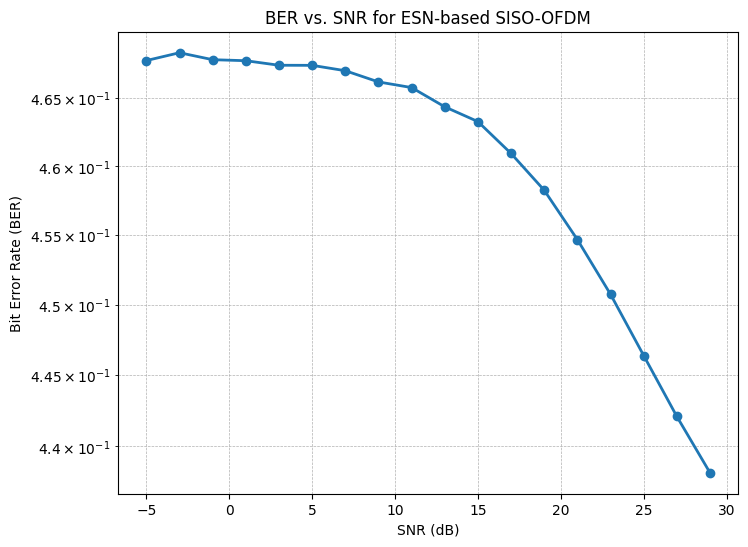

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of SNR values
snr_db_values = np.arange(-5, 31,2)
ber_values = []

# Loop over different SNR values
for snr_db in snr_db_values:
    # Generate data
    bits = np.random.randint(0, 2, (num_ofdm_symbols, num_subcarriers))
    qam_symbols = ofdm.modulate(bits)

    # Apply channel
    tx_signal_no_cp = ifft(qam_symbols, axis=1)
    rx_signal = np.dot(tx_signal_no_cp, channel_matrix.T)

    # Add cyclic prefix
    rx_signal_cp = np.hstack([rx_signal[:, -cp_length:], rx_signal])

    # Add noise
    noise_power = 10**(-snr_db/10)
    noise = np.sqrt(noise_power/2) * (np.random.randn(*rx_signal_cp.shape) + 1j * np.random.randn(*rx_signal_cp.shape))
    rx_signal_noisy = rx_signal_cp + noise

    # ESN implementation
    input_esn = np.hstack([rx_signal_noisy.real, rx_signal_noisy.imag])
    output_esn = np.hstack([qam_symbols.real, qam_symbols.imag])

    esn.train(input_esn, output_esn)
    predictions = esn.predict(input_esn)

    # Evaluate BER
    pred_symbols = predictions[:, :num_subcarriers] + 1j * predictions[:, num_subcarriers:]
    pred_bits = (pred_symbols.real > 0).astype(int)
    ber = np.mean(bits != pred_bits)
    ber_values.append(ber)

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_db_values, ber_values, 'o-', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs. SNR for ESN-based SISO-OFDM')
plt.show()


In [9]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.linalg import pinv as sc_pinv
import torch
from torch import nn, optim

np.random.seed(0)
torch.manual_seed(0)

# Parameters
N_t = 2
N_r = 2
N_c = 32
N_cp = 8
L = 4  # channel taps
N_u = 10
N_w = 1
mod_order = 4
bits_per_symbol = int(np.log2(mod_order))
snr_db_list = np.array([-10,-5,-1,0,5,10,15,20,25])
num_trials = 100
N_sym = 14
N_pilot = 4

# Constellation for QPSK
const = np.array([ -1-1j, -1+1j, 1-1j, 1+1j ]) / np.sqrt(2)

# Function to find closest symbol
def closest_symbol(s):
    if np.isscalar(s) or isinstance(s, complex):
        s = np.array([s])
        was_scalar = True
    else:
        was_scalar = False
    dist = np.abs(const[:, np.newaxis] - s)
    idx = np.argmin(dist, axis=0)
    result = const[idx]
    if was_scalar:
        return result[0]
    else:
        return result

# Function to get bits from symbols (simplified for QPSK using signs)
def get_bits(symbols):
    bits = ''
    for s in symbols.flatten():
        re = np.real(s)
        im = np.imag(s)
        bit0 = '1' if re > 0 else '0'
        bit1 = '1' if im > 0 else '0'
        bits += bit0 + bit1
    return bits

# Function to calculate BER
def calculate_ber(pred_symbols, true_symbols):
    true_bits = get_bits(true_symbols)
    pred_bits = get_bits(pred_symbols)
    errors = sum(b1 != b2 for b1, b2 in zip(true_bits, pred_bits))
    return errors / len(true_bits)

# Class for ESN (Reservoir Computing)
class ESN:
    def __init__(self, input_size, reservoir_size):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.W_in = np.random.uniform(-0.5, 0.5, (reservoir_size, input_size))
        W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(reservoir_size, reservoir_size) < 0.1
        W_res = W_res * mask
        rho = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res / rho * 0.9 if rho > 0 else W_res
        self.W_out = None

    def get_states(self, y_real_sym):
        N = y_real_sym.shape[0]
        r = np.zeros(self.reservoir_size)
        states = np.zeros((N, self.reservoir_size))
        for t in range(N):
            u = y_real_sym[t]
            r = np.tanh(self.W_res @ r + self.W_in @ u)
            states[t] = r
        return states

    def train(self, y_real, x_real):
        R = []
        for s in range(N_pilot):
            states = self.get_states(y_real[s])
            R.append(states)
        R = np.vstack(R)
        T = []
        for s in range(N_pilot):
            T.append(x_real[s])
        T = np.vstack(T)
        self.W_out = sc_pinv(R) @ T

    def predict(self, y_real_sym):
        states = self.get_states(y_real_sym)
        z = states @ self.W_out
        return z

# Binary Classifier for frequency domain
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Simulation
ber_rc_struct = np.zeros(len(snr_db_list))
ber_rc_net = np.zeros(len(snr_db_list))
ber_lmmse = np.zeros(len(snr_db_list))

for i, snr_db in enumerate(snr_db_list):
    ber_struct_trial = 0
    ber_net_trial = 0
    ber_lmmse_trial = 0
    for trial in range(num_trials):
        # Generate channel
        h = (np.random.randn(N_r, N_t, L) + 1j * np.random.randn(N_r, N_t, L)) / np.sqrt(2 * L)

        # Generate H_k for perfect CSI
        H_k = np.zeros((N_c, N_r, N_t), dtype=complex)
        for k in range(N_c):
            for l in range(L):
                H_k[k] += h[:,:,l] * np.exp(-1j * 2 * np.pi * k * l / N_c)

        # SNR
        E_b_N0 = 10 ** (snr_db / 10)
        N0 = 1 / (bits_per_symbol * E_b_N0)
        sigma = np.sqrt(N0 / 2)

        # Generate X
        X = np.random.choice(const, size=(N_sym, N_c, N_t))

        # To time domain
        x_time = ifft(X, axis=1) * np.sqrt(N_c)

        # Add CP
        x_cp = np.concatenate((x_time[:, -N_cp:, :], x_time), axis=1)

        # Received y_cp
        y_cp = np.zeros((N_sym, N_c + N_cp + L - 1, N_r), dtype=complex)
        for s in range(N_sym):
            for r in range(N_r):
                for t in range(N_t):
                    y_cp[s, :, r] += np.convolve(x_cp[s, :, t], h[r, t, :])

        # Add noise
        noise = (np.random.randn(*y_cp.shape) + 1j * np.random.randn(*y_cp.shape)) * sigma
        y_cp += noise

        # Remove CP
        y_time = y_cp[:, N_cp : N_cp + N_c, :]

        # Real representation
        y_real = np.concatenate((np.real(y_time), np.imag(y_time)), axis=-1)
        x_real = np.concatenate((np.real(x_time), np.imag(x_time)), axis=-1)

        # ESN
        input_size = 2 * N_r
        esn = ESN(input_size, N_u)
        esn.train(y_real, x_real)

        # For data symbols
        data_start = N_pilot
        pred_symbols_struct = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
        pred_symbols_net = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
        pred_symbols_lmmse = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
        true_symbols = X[data_start:, :, :]

        # Train binary classifiers using pilot Z
        z_pilot = np.zeros((N_pilot, N_c, 2 * N_t))
        for s in range(N_pilot):
            z_pilot[s] = esn.predict(y_real[s])
        z_pilot_complex = z_pilot[:, :, 0:N_t] + 1j * z_pilot[:, :, N_t:]
        Z_pilot = fft(z_pilot_complex, axis=1) / np.sqrt(N_c)

        input_pilot = torch.tensor(np.stack((np.real(Z_pilot).flatten(), np.imag(Z_pilot).flatten()), axis=1), dtype=torch.float32)

        # Labels for bits
        re_sign = np.sign(np.real(X[0:N_pilot]).flatten())
        im_sign = np.sign(np.imag(X[0:N_pilot]).flatten())
        label_bit0 = torch.tensor((re_sign > 0), dtype=torch.float32).view(-1, 1)
        label_bit1 = torch.tensor((im_sign > 0), dtype=torch.float32).view(-1, 1)

        # Train bit0
        model_bit0 = BinaryClassifier()
        optimizer0 = optim.SGD(model_bit0.parameters(), lr=0.01, momentum=0.001)
        loss_fn = nn.BCELoss()
        for epoch in range(800):
            out0 = model_bit0(input_pilot)
            loss0 = loss_fn(out0, label_bit0)
            optimizer0.zero_grad()
            loss0.backward()
            optimizer0.step()

        # Train bit1
        model_bit1 = BinaryClassifier()
        optimizer1 = optim.SGD(model_bit1.parameters(), lr=0.01, momentum=0.001)
        for epoch in range(800):
            out1 = model_bit1(input_pilot)
            loss1 = loss_fn(out1, label_bit1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        for s in range(data_start, N_sym):
            z_s = esn.predict(y_real[s])
            z_complex = z_s[:, 0:N_t] + 1j * z_s[:, N_t:]
            Z = fft(z_complex, axis=0) / np.sqrt(N_c)

            # For RCNet: closest
            pred_symbols_net[s - data_start] = closest_symbol(Z.flatten()).reshape(N_c, N_t)

            # For RC-Struct
            input_data = torch.tensor(np.stack((np.real(Z).flatten(), np.imag(Z).flatten()), axis=1), dtype=torch.float32)
            p_bit0 = model_bit0(input_data)
            p_bit1 = model_bit1(input_data)
            bit0 = (p_bit0 > 0.5).float().numpy().flatten()
            bit1 = (p_bit1 > 0.5).float().numpy().flatten()
            re = (2 * bit0 - 1) / np.sqrt(2)
            im = (2 * bit1 - 1) / np.sqrt(2)
            pred_symbols_struct[s - data_start] = (re + 1j * im).reshape(N_c, N_t)

            # For LMMSE
            Y = fft(y_time[s], axis=0) / np.sqrt(N_c)
            for k in range(N_c):
                h = H_k[k]
                inv = np.linalg.inv(h @ h.T.conj() + N0 * np.eye(N_r) + 1e-10 * np.eye(N_r))  # add small epsilon for stability
                w = h.T.conj() @ inv
                y_k = Y[k, :].T
                x_hat = w @ y_k
                pred_symbols_lmmse[s - data_start, k, :] = closest_symbol(x_hat)

        # Calculate BER for this trial
        ber_struct_trial += calculate_ber(pred_symbols_struct, true_symbols)
        ber_net_trial += calculate_ber(pred_symbols_net, true_symbols)
        ber_lmmse_trial += calculate_ber(pred_symbols_lmmse, true_symbols)

    ber_rc_struct[i] = ber_struct_trial / num_trials
    ber_rc_net[i] = ber_net_trial / num_trials
    ber_lmmse[i] = ber_lmmse_trial / num_trials

print("SNR dB:", snr_db_list)
print("BER RC-Struct:", ber_rc_struct)
print("BER RCNet:", ber_rc_net)
print("BER LMMSE:", ber_lmmse)

SNR dB: [-10  -5  -1   0   5  10  15  20  25]
BER RC-Struct: [0.42923437 0.39103906 0.3591875  0.34653906 0.31977344 0.32349219
 0.30748437 0.30990625 0.29760156]
BER RCNet: [0.42814844 0.38888281 0.35625    0.34319531 0.31947656 0.32085937
 0.30669531 0.30764063 0.29610938]
BER LMMSE: [0.29332813 0.20376562 0.12424219 0.11027344 0.04458594 0.01410156
 0.00417969 0.00154687 0.00057031]


In [13]:
def plot_constellation(symbols, title="Constellation Diagram", true=None):
    plt.figure(figsize=(5, 5))

    if true is not None:
        correct = np.isclose(symbols, true, atol=1e-4)
        plt.scatter(np.real(symbols[correct]), np.imag(symbols[correct]), s=8, c='blue', label='Correct')
        plt.scatter(np.real(symbols[~correct]), np.imag(symbols[~correct]), s=8, c='orange', label='Error')
    else:
        plt.scatter(np.real(symbols), np.imag(symbols), s=8, alpha=0.5, label='Predicted')

    qpsk_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j]) / np.sqrt(2)
    plt.scatter(np.real(qpsk_points), np.imag(qpsk_points), c='red', marker='x', s=100, label='QPSK Points')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.title(title)
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()


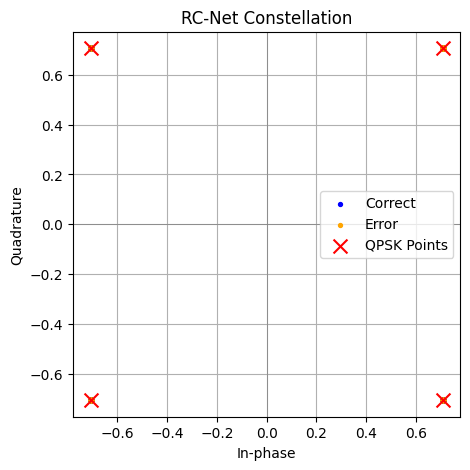

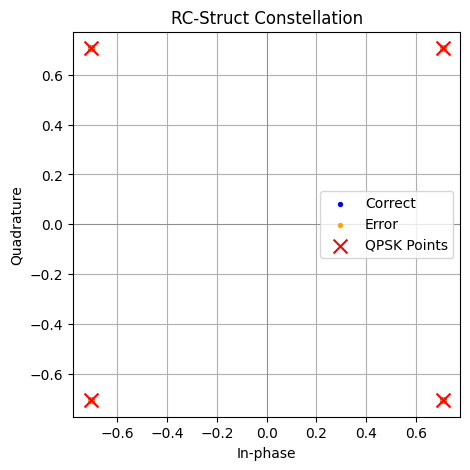

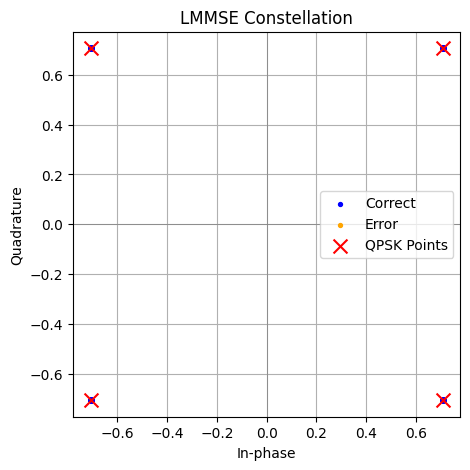

In [14]:
plot_constellation(flat_rcnet, title="RC-Net Constellation", true=flat_true)
plot_constellation(flat_rcstruct, title="RC-Struct Constellation", true=flat_true)
plot_constellation(flat_lmmse, title="LMMSE Constellation", true=flat_true)


RC_Stracture.

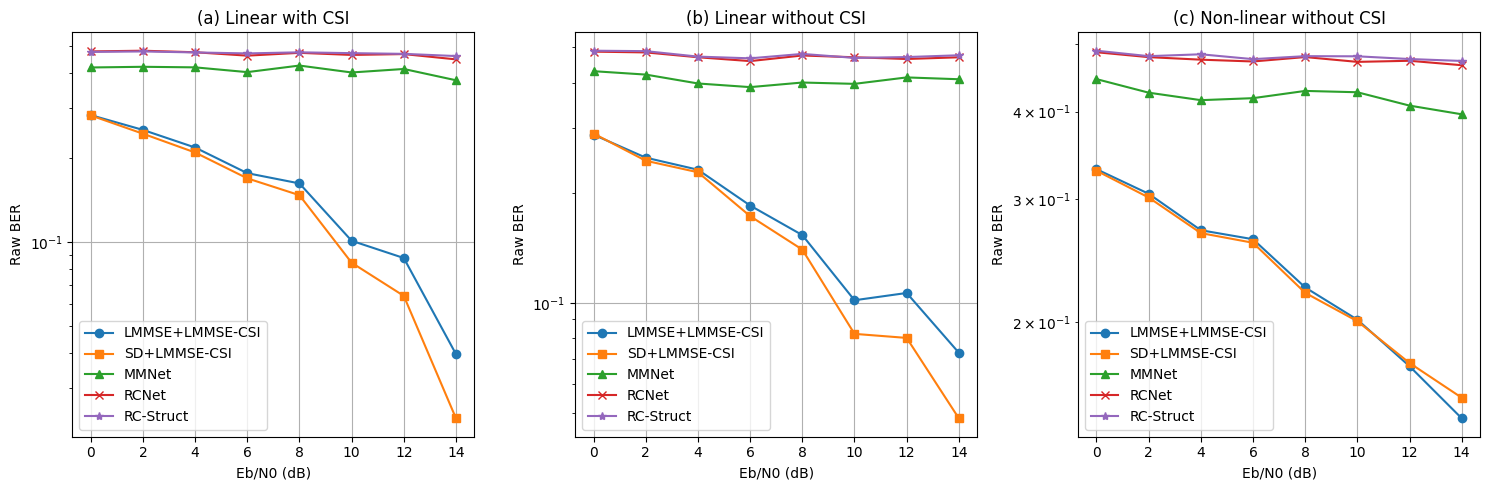

In [45]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.linalg import pinv as sc_pinv
import torch
from torch import nn, optim

np.random.seed(0)
torch.manual_seed(0)

# Parameters (user-defined; change as needed)
N_t = 2  # Number of transmitters
N_r = 2  # Number of receivers
N_c = 32  # Number of subcarriers
N_cp = 8  # Cyclic prefix length
L = 4  # Channel taps
N_u = 100  # Reservoir size
mod_order = 4  # Modulation order (16-QAM)
bits_per_symbol = int(np.log2(mod_order))
ebn0_db_list = np.arange(0, 15, 2)  # Eb/N0 range
num_trials = 10  # Number of trials (small for testing)
N_sym = 14  # Symbols per frame
N_pilot = 4  # Pilot symbols

# 16-QAM constellation
levels = np.array([-3, -1, 1, 3]) / np.sqrt(10)
const = (levels[:, np.newaxis] + 1j * levels).flatten()

# Function to find closest symbol (fixed to handle multi-dimensional inputs)
def closest_symbol(s):
    original_shape = s.shape
    s_flat = s.flatten()
    dist = np.abs(const[:, np.newaxis] - s_flat)
    idx = np.argmin(dist, axis=0)
    result = const[idx]
    return result.reshape(original_shape)

# Bit mapping for 16-QAM
def symbol_to_bits(sym):
    re = np.real(sym) * np.sqrt(10)
    im = np.imag(sym) * np.sqrt(10)
    re_bits = '00' if re < -2 else '01' if re < 0 else '11' if re < 2 else '10'
    im_bits = '00' if im < -2 else '01' if im < 0 else '11' if im < 2 else '10'
    return re_bits + im_bits

def get_bits(symbols):
    bits = ''
    for s in symbols.flatten():
        s_closest = closest_symbol(s)
        bits += symbol_to_bits(s_closest)
    return bits

# Calculate BER
def calculate_ber(pred_symbols, true_symbols):
    true_bits = get_bits(true_symbols)
    pred_bits = get_bits(pred_symbols)
    errors = sum(b1 != b2 for b1, b2 in zip(true_bits, pred_bits))
    return errors / len(true_bits)

# ESN class
class ESN:
    def __init__(self, input_size, reservoir_size):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.W_in = np.random.uniform(-0.5, 0.5, (reservoir_size, input_size))
        W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(reservoir_size, reservoir_size) < 0.1
        W_res = W_res * mask
        rho = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res / rho * 0.9 if rho > 0 else W_res
        self.W_out = None

    def get_states(self, y_real_sym):
        N = y_real_sym.shape[0]
        r = np.zeros(self.reservoir_size)
        states = np.zeros((N, self.reservoir_size))
        for t in range(N):
            u = y_real_sym[t]
            r = np.tanh(self.W_res @ r + self.W_in @ u)
            states[t] = r
        return states

    def train(self, y_real, x_real):
        R = []
        for s in range(N_pilot):
            states = self.get_states(y_real[s])
            R.append(states)
        R = np.vstack(R)
        T = []
        for s in range(N_pilot):
            T.append(x_real[s])
        T = np.vstack(T)
        self.W_out = sc_pinv(R) @ T

    def predict(self, y_real_sym):
        states = self.get_states(y_real_sym)
        z = states @ self.W_out
        return z

# BinaryClassifier
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)  # Simplified input to 1 (real or imag only)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# PamClassifier (simplified for real/imag separately)
class PamClassifier:
    def __init__(self):
        self.models = [BinaryClassifier() for _ in range(3)]  # 3 boundaries

    def train(self, z_input, true_levels):
        boundaries = [-2 / np.sqrt(10), 0, 2 / np.sqrt(10)]
        loss_fn = nn.BCELoss()
        for i, b in enumerate(boundaries):
            label_bin = (true_levels > b).astype(np.float32)
            label_t = torch.tensor(label_bin, dtype=torch.float32).view(-1, 1)
            optimizer = optim.SGD(self.models[i].parameters(), lr=0.01, momentum=0.001)
            for epoch in range(200):  # Reduced epochs for speed
                out = self.models[i](z_input)
                loss = loss_fn(out, label_t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    def predict_probs(self, z_input):
        probs = []
        for model in self.models:
            p = model(z_input).detach().numpy().squeeze()
            probs.append(p)
        return np.array(probs)

# Simplified MMNet
class MMNet(nn.Module):
    def __init__(self, N_r, N_t):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(N_r * 2, N_t * 2) for _ in range(3)])  # Reduced layers

    def forward(self, y_real):
        x = torch.zeros(y_real.shape[0], N_t * 2)
        for layer in self.layers:
            x = layer(y_real) + x
        return x

# Rapp PA
def rapp_pa(x, p=3, sat=1, gain=1):
    a = np.abs(x)
    return gain * x / (1 + (a / sat)**(2 * p))**(1 / (2 * p))

# Simplified Sphere Decoder (depth-first with pruning)
def sphere_decoder(y_k, h_k, const):
    Q, R = np.linalg.qr(h_k)
    y_tilde = Q.conj().T @ y_k.squeeze()
    m = h_k.shape[1]
    best_x = np.zeros(m, dtype=complex)
    best_dist = np.inf
    
    def dfs(level, partial_sum):
        nonlocal best_x, best_dist
        if level == -1:
            if partial_sum < best_dist:
                best_dist = partial_sum
                best_x = current_x.copy()
            return
        r_sum = 0
        for j in range(level + 1, m):
            r_sum += R[level, j] * current_x[j]
        est = (y_tilde[level] - r_sum) / R[level, level]
        sorted_const = sorted(const, key=lambda c: np.abs(c - est))
        for c in sorted_const:
            current_x[level] = c
            inc = np.abs(y_tilde[level] - r_sum - R[level, level] * c)**2
            if partial_sum + inc < best_dist:
                dfs(level - 1, partial_sum + inc)
    
    current_x = np.zeros(m, dtype=complex)
    dfs(m-1, 0)
    return best_x if best_dist < np.inf else closest_symbol(np.linalg.pinv(h_k) @ y_k).squeeze()

# BER storage
ber_lmmse = np.zeros((3, len(ebn0_db_list)))
ber_sd = np.zeros((3, len(ebn0_db_list)))
ber_mmnet = np.zeros((3, len(ebn0_db_list)))
ber_rc_net = np.zeros((3, len(ebn0_db_list)))
ber_rc_struct = np.zeros((3, len(ebn0_db_list)))

# Main simulation loop
for scen_idx in range(3):  # 0: linear with CSI, 1: linear no CSI, 2: non-linear no CSI
    has_csi = (scen_idx == 0)
    is_nonlinear = (scen_idx == 2)
    for i, ebn0_db in enumerate(ebn0_db_list):
        ber_lmmse_trial = 0
        ber_sd_trial = 0
        ber_mmnet_trial = 0
        ber_net_trial = 0
        ber_struct_trial = 0
        for trial in range(num_trials):
            h = (np.random.randn(N_r, N_t, L) + 1j * np.random.randn(N_r, N_t, L)) / np.sqrt(2 * L)
            H_k = np.zeros((N_c, N_r, N_t), dtype=complex)
            for k in range(N_c):
                for l in range(L):
                    H_k[k] += h[:,:,l] * np.exp(-1j * 2 * np.pi * k * l / N_c)
            E_b_N0 = 10 ** (ebn0_db / 10)
            N0 = 1 / E_b_N0
            sigma = np.sqrt(N0 / 2)
            X = np.random.choice(const, size=(N_sym, N_c, N_t))
            x_time = ifft(X, axis=1) * np.sqrt(N_c)
            if is_nonlinear:
                x_time = rapp_pa(x_time)
            x_cp = np.concatenate((x_time[:, -N_cp:, :], x_time), axis=1)
            y_cp = np.zeros((N_sym, N_c + N_cp + L - 1, N_r), dtype=complex)
            for s in range(N_sym):
                for r in range(N_r):
                    for t in range(N_t):
                        y_cp[s, :, r] += np.convolve(x_cp[s, :, t], h[r, t, :])
            noise = (np.random.randn(*y_cp.shape) + 1j * np.random.randn(*y_cp.shape)) * sigma
            y_cp += noise
            y_time = y_cp[:, N_cp : N_cp + N_c, :]
            y_real = np.concatenate((np.real(y_time), np.imag(y_time)), axis=-1)
            x_real = np.concatenate((np.real(x_time), np.imag(x_time)), axis=-1)
            input_size = 2 * N_r
            esn = ESN(input_size, N_u)
            esn.train(y_real, x_real)
            data_start = N_pilot
            pred_symbols_struct = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_net = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_lmmse = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_sd = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_mmnet = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            true_symbols = X[data_start:, :, :]
            z_pilot = np.zeros((N_pilot, N_c, 2 * N_t))
            for s in range(N_pilot):
                z_pilot[s] = esn.predict(y_real[s])
            z_pilot_complex = z_pilot[:, :, 0:N_t] + 1j * z_pilot[:, :, N_t:]
            Z_pilot = fft(z_pilot_complex, axis=1) / np.sqrt(N_c)
            z_re_input = torch.tensor(np.real(Z_pilot).flatten().reshape(-1, 1), dtype=torch.float32)
            z_im_input = torch.tensor(np.imag(Z_pilot).flatten().reshape(-1, 1), dtype=torch.float32)
            x_re = np.real(X[0:N_pilot]).flatten() * np.sqrt(10)
            x_im = np.imag(X[0:N_pilot]).flatten() * np.sqrt(10)
            pam_re = PamClassifier()
            pam_re.train(z_re_input, x_re)
            pam_im = PamClassifier()
            pam_im.train(z_im_input, x_im)
            mmnet = MMNet(N_r, N_t)
            optimizer_mm = optim.Adam(mmnet.parameters(), lr=0.01)
            loss_fn = nn.MSELoss()
            y_pilot_freq = fft(y_time[0:N_pilot], axis=1) / np.sqrt(N_c)
            y_pilot_real = np.concatenate((np.real(y_pilot_freq), np.imag(y_pilot_freq)), axis=-1).reshape(N_pilot * N_c, -1)
            x_pilot_real = np.concatenate((np.real(X[0:N_pilot]), np.imag(X[0:N_pilot])), axis=-1).reshape(N_pilot * N_c, -1)
            y_pilot_t = torch.tensor(y_pilot_real, dtype=torch.float32)
            x_pilot_t = torch.tensor(x_pilot_real, dtype=torch.float32)
            for epoch in range(100):
                out = mmnet(y_pilot_t)
                loss = loss_fn(out, x_pilot_t)
                optimizer_mm.zero_grad()
                loss.backward()
                optimizer_mm.step()
            for s in range(data_start, N_sym):
                z_s = esn.predict(y_real[s])
                z_complex = z_s[:, 0:N_t] + 1j * z_s[:, N_t:]
                Z = fft(z_complex, axis=0) / np.sqrt(N_c)
                pred_symbols_net[s - data_start] = closest_symbol(Z)
                z_re_input_data = torch.tensor(np.real(Z).flatten().reshape(-1, 1), dtype=torch.float32)
                z_im_input_data = torch.tensor(np.imag(Z).flatten().reshape(-1, 1), dtype=torch.float32)
                probs_re = pam_re.predict_probs(z_re_input_data)
                probs_im = pam_im.predict_probs(z_im_input_data)
                bit0_re = probs_re[1] > 0.5
                bit1_re = (probs_re[0] + probs_re[2]) / 2 > 0.5
                level_re = (bit0_re.astype(float) * 2 - 1) * (1 + 2 * bit1_re.astype(float)) / np.sqrt(10)
                bit0_im = probs_im[1] > 0.5
                bit1_im = (probs_im[0] + probs_im[2]) / 2 > 0.5
                level_im = (bit0_im.astype(float) * 2 - 1) * (1 + 2 * bit1_im.astype(float)) / np.sqrt(10)
                pred_symbols_struct[s - data_start] = level_re.reshape(N_c, N_t) + 1j * level_im.reshape(N_c, N_t)
                Y = fft(y_time[s], axis=0) / np.sqrt(N_c)
                for k in range(N_c):
                    h = H_k[k]
                    inv = np.linalg.inv(h @ h.T.conj() + N0 * np.eye(N_r) + 1e-10 * np.eye(N_r))
                    w = h.T.conj() @ inv
                    y_k = Y[k, :].T
                    x_hat = w @ y_k
                    pred_symbols_lmmse[s - data_start, k, :] = closest_symbol(x_hat)
                for k in range(N_c):
                    y_k = Y[k, :].T[:, np.newaxis]
                    h_k = H_k[k]
                    pred_symbols_sd[s - data_start, k, :] = sphere_decoder(y_k, h_k, const)
                y_real_s = np.concatenate((np.real(Y), np.imag(Y)), axis=-1).reshape(N_c, -1)
                out = mmnet(torch.tensor(y_real_s, dtype=torch.float32)).detach().numpy()
                re = out[:, :N_t]
                im = out[:, N_t:]
                pred_symbols_mmnet[s - data_start] = closest_symbol(re + 1j * im)
            ber_struct_trial += calculate_ber(pred_symbols_struct, true_symbols)
            ber_net_trial += calculate_ber(pred_symbols_net, true_symbols)
            ber_lmmse_trial += calculate_ber(pred_symbols_lmmse, true_symbols)
            ber_sd_trial += calculate_ber(pred_symbols_sd, true_symbols)
            ber_mmnet_trial += calculate_ber(pred_symbols_mmnet, true_symbols)
        ber_rc_struct[scen_idx, i] = ber_struct_trial / num_trials
        ber_rc_net[scen_idx, i] = ber_net_trial / num_trials
        ber_lmmse[scen_idx, i] = ber_lmmse_trial / num_trials
        ber_sd[scen_idx, i] = ber_sd_trial / num_trials
        ber_mmnet[scen_idx, i] = ber_mmnet_trial / num_trials

# Plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['(a) Linear with CSI', '(b) Linear without CSI', '(c) Non-linear without CSI']
for idx in range(3):
    axs[idx].semilogy(ebn0_db_list, ber_lmmse[idx], 'o-', label='LMMSE+LMMSE-CSI')
    axs[idx].semilogy(ebn0_db_list, ber_sd[idx], 's-', label='SD+LMMSE-CSI')
    axs[idx].semilogy(ebn0_db_list, ber_mmnet[idx], '^-', label='MMNet')
    axs[idx].semilogy(ebn0_db_list, ber_rc_net[idx], 'x-', label='RCNet')
    axs[idx].semilogy(ebn0_db_list, ber_rc_struct[idx], '*-', label='RC-Struct')
    axs[idx].set_xlabel('Eb/N0 (dB)')
    axs[idx].set_ylabel('Raw BER')
    axs[idx].set_title(titles[idx])
    axs[idx].grid(True)
    axs[idx].legend()
plt.tight_layout()
plt.show()

In [57]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.linalg import pinv as sc_pinv
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

# Parameters (user-defined; change as needed)
N_t = 2  # Number of transmitters
N_r = 2  # Number of receivers
N_c = 32  # Number of subcarriers
N_cp = 8  # Cyclic prefix length
L = 4  # Channel taps
N_u = 100  # Reservoir size increased from 16
mod_order = 4  # Modulation order (4-QAM = QPSK)
bits_per_symbol = int(np.log2(mod_order))
ebn0_db_list = np.arange(0, 21, 2)  # Eb/N0 range extended to 20 dB
num_trials = 10  # Number of trials (small for testing)
N_sym = 14  # Symbols per frame
N_pilot = 8  # Pilot symbols increased from 4

# 4-QAM (QPSK) constellation
const = np.array([ -1-1j, -1+1j, 1-1j, 1+1j ]) / np.sqrt(2)

# Function to find closest symbol (fixed to handle multi-dimensional inputs)
def closest_symbol(s):
    original_shape = s.shape
    s_flat = s.flatten()
    dist = np.abs(const[:, np.newaxis] - s_flat)
    idx = np.argmin(dist, axis=0)
    result = const[idx]
    return result.reshape(original_shape)

# Bit mapping for QPSK
def symbol_to_bits(sym):
    re = np.real(sym) * np.sqrt(2)  # Denormalize
    im = np.imag(sym) * np.sqrt(2)
    re_bit = '0' if re < 0 else '1'
    im_bit = '0' if im < 0 else '1'
    return re_bit + im_bit

def get_bits(symbols):
    bits = ''
    for s in symbols.flatten():
        s_closest = closest_symbol(s)
        bits += symbol_to_bits(s_closest)
    return bits

# Calculate BER
def calculate_ber(pred_symbols, true_symbols):
    true_bits = get_bits(true_symbols)
    pred_bits = get_bits(pred_symbols)
    errors = sum(b1 != b2 for b1, b2 in zip(true_bits, pred_bits))
    return errors / len(true_bits)

# Class for ESN (Reservoir Computing) - Support cascading
class ESN:
    def __init__(self, input_size, reservoir_size):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.W_in = np.random.uniform(-0.5, 0.5, (reservoir_size, input_size))
        W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(reservoir_size, reservoir_size) < 0.1
        W_res = W_res * mask
        rho = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res / rho * 0.9 if rho > 0 else W_res
        self.W_out = None

    def get_states(self, y_real_sym):
        N = y_real_sym.shape[0]
        r = np.zeros(self.reservoir_size)
        states = np.zeros((N, self.reservoir_size))
        for t in range(N):
            u = y_real_sym[t]
            r = np.tanh(self.W_res @ r + self.W_in @ u)
            states[t] = r
        return states

    def train(self, y_real, x_real):
        R = []
        for s in range(N_pilot):
            states = self.get_states(y_real[s])
            R.append(states)
        R = np.vstack(R)
        T = []
        for s in range(N_pilot):
            T.append(x_real[s])
        T = np.vstack(T)
        self.W_out = sc_pinv(R) @ T

    def predict(self, y_real_sym, show_states=False):
        states = self.get_states(y_real_sym)
        z = states @ self.W_out
        return z

# Binary Classifier for frequency domain (input size 2 for re+im)
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# PAM Classifier (simplified for QPSK: 1 binary per dimension for sign)
class PamClassifier:
    def __init__(self):
        self.model = BinaryClassifier()  # Only 1 for boundary at 0

    def train(self, z_input_2d, true_levels):
        boundary = 0
        label_bin = (true_levels > boundary).astype(np.float32)
        label_t = torch.tensor(label_bin, dtype=torch.float32).view(-1, 1)
        optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.001)
        loss_fn = nn.BCELoss()
        for epoch in range(2000):  # Increased from 800
            out = self.model(z_input_2d)
            loss = loss_fn(out, label_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def predict_probs(self, z_input_2d):
        p = self.model(z_input_2d).detach().numpy().squeeze()
        return p

# Detection for QPSK (sign decision)
def pam_detect(probs):
    level = (2 * (probs > 0.5).astype(float) - 1) / np.sqrt(2)
    return level

# Simplified MMNet
class MMNet(nn.Module):
    def __init__(self, N_r, N_t):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(N_r * 2, N_t * 2) for _ in range(3)])  # Reduced layers

    def forward(self, y_real):
        x = torch.zeros(y_real.shape[0], N_t * 2)
        for layer in self.layers:
            x = layer(y_real) + x
        return x

# Rapp PA
def rapp_pa(x, p=3, sat=1, gain=1):
    a = np.abs(x)
    return gain * x / (1 + (a / sat)**(2 * p))**(1 / (2 * p))

# Simplified Sphere Decoder (bottom-up)
def sphere_decoder(y_k, h_k, const):
    Q, R = np.linalg.qr(h_k)
    y_tilde = Q.conj().T @ y_k.squeeze()
    m = h_k.shape[1]
    best_x = np.zeros(m, dtype=complex)
    best_dist = np.inf
    
    current_x = np.zeros(m, dtype=complex)
    
    def dfs(level, partial_sum):
        nonlocal best_x, best_dist
        if level == -1:
            if partial_sum < best_dist:
                best_dist = partial_sum
                best_x = current_x.copy()
            return
        r_sum = 0
        for j in range(level + 1, m):
            r_sum += R[level, j] * current_x[j]
        est = (y_tilde[level] - r_sum) / R[level, level]
        sorted_const = sorted(const, key=lambda c: np.abs(c - est))
        for c in sorted_const:
            current_x[level] = c
            inc = np.abs(y_tilde[level] - r_sum - R[level, level] * c)**2
            if partial_sum + inc < best_dist:
                dfs(level - 1, partial_sum + inc)
    
    dfs(m - 1, 0)
    return best_x if best_dist < np.inf else closest_symbol(np.linalg.pinv(h_k) @ y_k).squeeze()

# BER storage
ber_lmmse = np.zeros((3, len(ebn0_db_list)))
ber_sd = np.zeros((3, len(ebn0_db_list)))
ber_mmnet = np.zeros((3, len(ebn0_db_list)))
ber_rc_net = np.zeros((3, len(ebn0_db_list)))
ber_rc_struct = np.zeros((3, len(ebn0_db_list)))

# Main simulation loop
for scen_idx in range(3):  # 0: linear with CSI, 1: linear no CSI, 2: non-linear no CSI
    has_csi = (scen_idx == 0)
    is_nonlinear = (scen_idx == 2)
    for i, ebn0_db in enumerate(ebn0_db_list):
        ber_lmmse_trial = 0
        ber_sd_trial = 0
        ber_mmnet_trial = 0
        ber_net_trial = 0
        ber_struct_trial = 0
        for trial in range(num_trials):
            h = (np.random.randn(N_r, N_t, L) + 1j * np.random.randn(N_r, N_t, L)) / np.sqrt(2 * L)
            H_k = np.zeros((N_c, N_r, N_t), dtype=complex)
            for k in range(N_c):
                for l in range(L):
                    H_k[k] += h[:,:,l] * np.exp(-1j * 2 * np.pi * k * l / N_c)
            E_b_N0 = 10 ** (ebn0_db / 10)
            N0 = 1 / E_b_N0
            sigma = np.sqrt(N0 / 2)
            X = np.random.choice(const, size=(N_sym, N_c, N_t))
            x_time = ifft(X, axis=1) * np.sqrt(N_c)
            if is_nonlinear:
                x_time = rapp_pa(x_time)
            x_cp = np.concatenate((x_time[:, -N_cp:, :], x_time), axis=1)
            y_cp = np.zeros((N_sym, N_c + N_cp + L - 1, N_r), dtype=complex)
            for s in range(N_sym):
                for r in range(N_r):
                    for t in range(N_t):
                        y_cp[s, :, r] += np.convolve(x_cp[s, :, t], h[r, t, :])
            noise = (np.random.randn(*y_cp.shape) + 1j * np.random.randn(*y_cp.shape)) * sigma
            y_cp += noise
            y_time = y_cp[:, N_cp : N_cp + N_c, :]
            y_real = np.concatenate((np.real(y_time), np.imag(y_time)), axis=-1)
            x_real = np.concatenate((np.real(x_time), np.imag(x_time)), axis=-1)
            input_size = 2 * N_r
            # Cascaded ESN: Two instances
            esn1 = ESN(input_size, N_u)
            esn1.train(y_real, x_real)
            # Generate intermediate for pilots
            intermediate = []
            for s in range(N_pilot):
                intermediate.append(esn1.predict(y_real[s]))
            intermediate = np.array(intermediate)
            esn2 = ESN(2 * N_t, N_u)  # Input to second is z from first
            esn2.train(intermediate, x_real)
            data_start = N_pilot
            pred_symbols_struct = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_net = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_lmmse = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_sd = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            pred_symbols_mmnet = np.zeros((N_sym - data_start, N_c, N_t), dtype=complex)
            true_symbols = X[data_start:, :, :]
            z_pilot = np.zeros((N_pilot, N_c, 2 * N_t))
            for s in range(N_pilot):
                z1 = esn1.predict(y_real[s])
                z_pilot[s] = esn2.predict(z1)
            z_pilot_complex = z_pilot[:, :, 0:N_t] + 1j * z_pilot[:, :, N_t:]
            Z_pilot = fft(z_pilot_complex, axis=1) / np.sqrt(N_c)
            z_input_2d = torch.tensor(np.stack((np.real(Z_pilot).flatten(), np.imag(Z_pilot).flatten()), axis=1), dtype=torch.float32)
            x_re = np.real(X[0:N_pilot]).flatten() * np.sqrt(2)
            x_im = np.imag(X[0:N_pilot]).flatten() * np.sqrt(2)
            pam_re = PamClassifier()
            pam_re.train(z_input_2d, x_re)
            pam_im = PamClassifier()
            pam_im.train(z_input_2d, x_im)
            mmnet = MMNet(N_r, N_t)
            optimizer_mm = optim.Adam(mmnet.parameters(), lr=0.01)
            loss_fn = nn.MSELoss()
            y_pilot_freq = fft(y_time[0:N_pilot], axis=1) / np.sqrt(N_c)
            y_pilot_real = np.concatenate((np.real(y_pilot_freq), np.imag(y_pilot_freq)), axis=-1).reshape(N_pilot * N_c, -1)
            x_pilot_real = np.concatenate((np.real(X[0:N_pilot]), np.imag(X[0:N_pilot])), axis=-1).reshape(N_pilot * N_c, -1)
            y_pilot_t = torch.tensor(y_pilot_real, dtype=torch.float32)
            x_pilot_t = torch.tensor(x_pilot_real, dtype=torch.float32)
            for epoch in range(500):  # Increased from 100
                out = mmnet(y_pilot_t)
                loss = loss_fn(out, x_pilot_t)
                optimizer_mm.zero_grad()
                loss.backward()
                optimizer_mm.step()
            
            # LS Channel estimation for no CSI scenarios
            H_k_est = np.zeros((N_c, N_r, N_t), dtype=complex)
            for k in range(N_c):
                Y_k = y_pilot_freq[:, k, :].T  # N_r x N_pilot
                X_k = X[0:N_pilot, k, :].T  # N_t x N_pilot
                H_k_est[k] = Y_k @ np.linalg.pinv(X_k, rcond=1e-10)
            
            for s in range(data_start, N_sym):
                z1 = esn1.predict(y_real[s])
                z_s = esn2.predict(z1)
                z_complex = z_s[:, 0:N_t] + 1j * z_s[:, N_t:]
                Z = fft(z_complex, axis=0) / np.sqrt(N_c)
                pred_symbols_net[s - data_start] = closest_symbol(Z)
                z_input_data_2d = torch.tensor(np.stack((np.real(Z).flatten(), np.imag(Z).flatten()), axis=1), dtype=torch.float32)
                probs_re = pam_re.predict_probs(z_input_data_2d)
                probs_im = pam_im.predict_probs(z_input_data_2d)
                level_re = pam_detect(probs_re)
                level_im = pam_detect(probs_im)
                pred_symbols_struct[s - data_start] = level_re.reshape(N_c, N_t) + 1j * level_im.reshape(N_c, N_t)
                Y = fft(y_time[s], axis=0) / np.sqrt(N_c)
                h_use = H_k if has_csi else H_k_est
                for k in range(N_c):
                    h = h_use[k]
                    inv = np.linalg.inv(h @ np.conj(h).T + N0 * np.eye(N_r) + 1e-10 * np.eye(N_r))
                    w = np.conj(h).T @ inv
                    y_k = Y[k, :].T
                    x_hat = w @ y_k
                    pred_symbols_lmmse[s - data_start, k, :] = closest_symbol(x_hat)
                for k in range(N_c):
                    y_k = Y[k, :].T[:, np.newaxis]
                    h_k = h_use[k]
                    pred_symbols_sd[s - data_start, k, :] = sphere_decoder(y_k, h_k, const)
                y_real_s = np.concatenate((np.real(Y), np.imag(Y)), axis=-1).reshape(N_c, -1)
                out = mmnet(torch.tensor(y_real_s, dtype=torch.float32)).detach().numpy()
                re = out[:, :N_t]
                im = out[:, N_t:]
                pred_symbols_mmnet[s - data_start] = closest_symbol(re + 1j * im)
            ber_struct = calculate_ber(pred_symbols_struct, true_symbols)
            ber_net = calculate_ber(pred_symbols_net, true_symbols)
            ber_lmmse_val = calculate_ber(pred_symbols_lmmse, true_symbols)
            ber_sd_val = calculate_ber(pred_symbols_sd, true_symbols)
            ber_mmnet_val = calculate_ber(pred_symbols_mmnet, true_symbols)
            ber_struct_trial += ber_struct
            ber_net_trial += ber_net
            ber_lmmse_trial += ber_lmmse_val
            ber_sd_trial += ber_sd_val
            ber_mmnet_trial += ber_mmnet_val
        ber_rc_struct[scen_idx, i] = ber_struct_trial / num_trials
        ber_rc_net[scen_idx, i] = ber_net_trial / num_trials
        ber_lmmse[scen_idx, i] = ber_lmmse_trial / num_trials
        ber_sd[scen_idx, i] = ber_sd_trial / num_trials
        ber_mmnet[scen_idx, i] = ber_mmnet_trial / num_trials
        print(f"Scenario {scen_idx}, Eb/N0 {ebn0_db}: Avg BER RC-Struct {ber_rc_struct[scen_idx, i]}, RCNet {ber_rc_net[scen_idx, i]}, LMMSE {ber_lmmse[scen_idx, i]}, SD {ber_sd[scen_idx, i]}, MMNet {ber_mmnet[scen_idx, i]}")

# Plot BER curves with paper-like colors
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['(a) Linear with CSI', '(b) Linear without CSI', '(c) Non-linear without CSI']
colors = ['blue', 'green', 'orange', 'red', 'purple']  # From paper image
for idx in range(3):
    axs[idx].semilogy(ebn0_db_list, ber_lmmse[idx], 'o-', color=colors[0], label='LMMSE+LMMSE-CSI')
    axs[idx].semilogy(ebn0_db_list, ber_sd[idx], 's-', color=colors[1], label='SD+LMMSE-CSI')
    axs[idx].semilogy(ebn0_db_list, ber_mmnet[idx], '^-', color=colors[2], label='MMNet')
    axs[idx].semilogy(ebn0_db_list, ber_rc_net[idx], 'x-', color=colors[3], label='RCNet')
    axs[idx].semilogy(ebn0_db_list, ber_rc_struct[idx], '*-', color=colors[4], label='RC-Struct')
    axs[idx].set_xlabel('Eb/N0 (dB)')
    axs[idx].set_ylabel('Raw BER')
    axs[idx].set_title(titles[idx])
    axs[idx].grid(True)
    axs[idx].legend()
plt.tight_layout()
plt.show()

# Constellation diagram (for last true vs predicted of RC-Struct in last scenario)
true_const = true_symbols[-1].flatten()
pred_const = pred_symbols_struct[-1].flatten()
plt.scatter(np.real(true_const), np.imag(true_const), label='True Symbols', marker='o')
plt.scatter(np.real(pred_const), np.imag(pred_const), label='Predicted (RC-Struct)', marker='x')
plt.title('Constellation Diagram (True vs Predicted)')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend()
plt.grid(True)
plt.show()
print("Constellation diagram plotted")

Scenario 0, Eb/N0 0: Avg BER RC-Struct 0.43984375, RCNet 0.4384114583333333, LMMSE 0.16015624999999997, SD 0.152734375, MMNet 0.350390625
Scenario 0, Eb/N0 2: Avg BER RC-Struct 0.4313802083333334, RCNet 0.43294270833333337, LMMSE 0.1234375, SD 0.108984375, MMNet 0.35260416666666666
Scenario 0, Eb/N0 4: Avg BER RC-Struct 0.4408854166666667, RCNet 0.4401041666666667, LMMSE 0.08802083333333334, SD 0.071875, MMNet 0.3497395833333333
Scenario 0, Eb/N0 6: Avg BER RC-Struct 0.402734375, RCNet 0.40078125, LMMSE 0.071484375, SD 0.04791666666666667, MMNet 0.3217447916666667
Scenario 0, Eb/N0 8: Avg BER RC-Struct 0.39322916666666663, RCNet 0.3940104166666667, LMMSE 0.03697916666666667, SD 0.014322916666666666, MMNet 0.337890625
Scenario 0, Eb/N0 10: Avg BER RC-Struct 0.32903645833333334, RCNet 0.32565104166666664, LMMSE 0.028515625, SD 0.013151041666666669, MMNet 0.2734375
Scenario 0, Eb/N0 12: Avg BER RC-Struct 0.34010416666666665, RCNet 0.340234375, LMMSE 0.025, SD 0.007421875, MMNet 0.26536458

KeyboardInterrupt: 

In [28]:
# A simple implementation of the Echo State Network (ESN) concept
# for symbol detection, inspired by the paper.
# This code simulates a very basic wireless channel and demonstrates the
# core idea of using an ESN to detect transmitted symbols without
# explicit channel estimation. It does not replicate the full complexity
# of the paper's MIMO-OFDM system.

import numpy as np

class ESN:
    """
    A basic Echo State Network implementation.
    """
    def __init__(self, n_inputs, n_outputs, n_neurons, spectral_radius, sparsity):
        """
        Initializes the ESN with random weights.

        Args:
            n_inputs (int): Number of input nodes.
            n_outputs (int): Number of output nodes.
            n_neurons (int): Number of reservoir neurons.
            spectral_radius (float): Controls the internal dynamics of the reservoir.
            sparsity (float): The fraction of non-zero internal weights.
        """
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_neurons = n_neurons

        # Randomly initialize input weights (Win)
        self.Win = (np.random.rand(self.n_neurons, 1 + self.n_inputs) - 0.5) * 0.1

        # Randomly initialize reservoir weights (W) with sparsity
        self.W = np.random.rand(self.n_neurons, self.n_neurons) - 0.5
        mask = np.random.rand(*self.W.shape) > sparsity
        self.W[mask] = 0

        # Scale the reservoir weights to the desired spectral radius
        radius = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W = self.W * (spectral_radius / radius)

        # Output weights are learned later
        self.Wout = None
        self.state = np.zeros(self.n_neurons)

    def _update_state(self, input_vector):
        """
        Updates the ESN's internal state based on the current input.
        """
        # Concatenate the bias (1), input, and previous state for the update
        input_with_bias = np.concatenate(([1], input_vector))
        
        # Update the state using the tanh activation function
        # This is a simplified update rule for demonstration purposes
        self.state = np.tanh(np.dot(self.Win, input_with_bias) + np.dot(self.W, self.state))
        
        return self.state

    def train(self, inputs, teacher_outputs):
        """
        Trains the ESN by learning the output weights (Wout)
        using linear regression.

        Args:
            inputs (np.ndarray): Training input data.
            teacher_outputs (np.ndarray): Corresponding target output data.
        """
        # Create a state matrix for training
        training_states = np.zeros((self.n_neurons, len(inputs)))
        
        # Run the training inputs through the ESN to collect states
        for i, input_vector in enumerate(inputs):
            self._update_state(input_vector)
            training_states[:, i] = self.state

        # Add a bias term to the states for linear regression
        training_states_with_bias = np.vstack(([1] * len(inputs), training_states)).T
        
        # Solve for the output weights (Wout) using pseudo-inverse
        self.Wout = np.dot(np.linalg.pinv(training_states_with_bias), teacher_outputs)
    
    def predict(self, inputs):
        """
        Uses the trained ESN to predict outputs for new inputs.
        """
        self.state = np.zeros(self.n_neurons) # Reset state for prediction
        predictions = []
        for input_vector in inputs:
            self._update_state(input_vector)
            state_with_bias = np.concatenate(([1], self.state))
            # FIX: Swapped the order of the dot product to align the shapes.
            output = np.dot(state_with_bias, self.Wout)
            predictions.append(output)
        return np.array(predictions)

def generate_qpsk_symbols(num_symbols):
    """
    Generates random QPSK symbols.
    """
    symbols = np.random.randint(0, 4, size=num_symbols)
    qpsk_mapping = {0: 1+1j, 1: -1+1j, 2: -1-1j, 3: 1-1j}
    return np.array([qpsk_mapping[s] for s in symbols])

def simulate_channel(signal, noise_level):
    """
    Simulates a simple wireless channel with frequency-selective fading and AWGN.
    This is a highly simplified model.
    """
    channel_impulse = np.array([0.8, 0.3j, -0.1])
    convolved_signal = np.convolve(signal, channel_impulse, 'same')
    noise = np.random.normal(0, noise_level, len(signal)) + 1j * np.random.normal(0, noise_level, len(signal))
    received_signal = convolved_signal + noise
    return received_signal

if __name__ == '__main__':
    # --- ESN Parameters ---
    N_INPUTS = 2  # Real and imaginary part of the signal
    N_OUTPUTS = 2 # Real and imaginary part of the detected symbol
    N_NEURONS = 100
    SPECTRAL_RADIUS = 0.999

    SPARSITY = 0.9

    # --- Simulation Parameters ---
    NUM_SYMBOLS = 10000
    TRAINING_RATIO = 0.5
    NOISE_LEVEL = 0.7

    print("Initializing ESN and simulating data...")
    
    # 1. Generate QPSK symbols
    transmitted_symbols = generate_qpsk_symbols(NUM_SYMBOLS)
    
    # 2. Simulate the wireless channel
    received_symbols = simulate_channel(transmitted_symbols, NOISE_LEVEL)

    # 3. Prepare data for the ESN
    # The ESN inputs will be the received symbols (real and imaginary parts)
    # The ESN outputs will be the transmitted symbols (real and imaginary parts)
    esn_inputs = np.array([[s.real, s.imag] for s in received_symbols])
    esn_targets = np.array([[s.real, s.imag] for s in transmitted_symbols])

    # 4. Split data into training and testing sets
    split_idx = int(NUM_SYMBOLS * TRAINING_RATIO)
    train_inputs = esn_inputs[:split_idx]
    train_targets = esn_targets[:split_idx]
    test_inputs = esn_inputs[split_idx:]
    test_targets = esn_targets[split_idx:]

    # 5. Initialize and train the ESN
    esn = ESN(N_INPUTS, N_OUTPUTS, N_NEURONS, SPECTRAL_RADIUS, SPARSITY)
    print(f"Training ESN on {len(train_inputs)} symbols...")
    esn.train(train_inputs, train_targets)
    print("Training complete.")

    # 6. Make predictions on the test data
    print(f"Testing ESN on {len(test_inputs)} symbols...")
    predictions = esn.predict(test_inputs)

    # 7. Evaluate performance (simplified symbol detection)
    # Map the predicted real/imaginary values back to the nearest QPSK symbol
    detected_symbols = []
    for pred in predictions:
        pred_complex = complex(pred[0], pred[1])
        distances = np.abs(np.array([1+1j, -1+1j, -1-1j, 1-1j]) - pred_complex)
        detected_symbol = np.array([1+1j, -1+1j, -1-1j, 1-1j])[np.argmin(distances)]
        detected_symbols.append(detected_symbol)
    
    # Calculate the Symbol Error Rate (SER)
    true_symbols_complex = np.array([complex(t[0], t[1]) for t in test_targets])
    errors = np.sum(np.array(detected_symbols) != true_symbols_complex)
    ser = errors / len(detected_symbols)
    
    print("\n--- Simulation Results ---")
    print(f"Number of test symbols: {len(test_inputs)}")
    print(f"Total symbol errors: {errors}")
    print(f"Symbol Error Rate (SER): {ser:.4f}")



Initializing ESN and simulating data...
Training ESN on 5000 symbols...
Training complete.
Testing ESN on 5000 symbols...

--- Simulation Results ---
Number of test symbols: 5000
Total symbol errors: 1256
Symbol Error Rate (SER): 0.2512


Brain inspired.

In [66]:
import numpy as np
from scipy.linalg import eigh
from sklearn.linear_model import Ridge
from itertools import product

# System parameters
N_sc = 64
N_cp = 16
N_tx = 2
N_rx = 2
mod_order = 4  # QPSK
Q = 4
N_test = 100
num_trials = 5  # Reduced for speed
window_size = 128
reservoir_size = 256
spectral_radius = 0.95
input_scale = 0.5
sparsity = 0.05
lambda_reg = 1e-4
P = 10

# PA parameters
rho = 3.0
x_sat = 1.0
ibo_db_linear = 10.0  # Linear
ibo_db_nonlinear = 2.2  # Nonlinear

# Constellation
constellation = np.array([(1+1j), (1-1j), (-1+1j), (-1-1j)]) / np.sqrt(2)
bit_map = {0: [0,0], 1: [0,1], 2: [1,0], 3: [1,1]}  # Gray coding

# Generate symbols
def generate_symbols(N_symbols, N_tx, N_sc, mod_order):
    indices = np.random.randint(0, mod_order, size=(N_symbols, N_tx, N_sc))
    symbols_freq = constellation[indices]
    bits = np.zeros((N_symbols, N_tx, N_sc, 2), dtype=int)
    for s in range(N_symbols):
        for a in range(N_tx):
            for sc in range(N_sc):
                bits[s,a,sc] = bit_map[indices[s,a,sc]]
    return symbols_freq, bits

# OFDM modulate
def ofdm_modulate(symbols_freq, N_sc, N_cp):
    symbols_time = np.fft.ifft(symbols_freq, n=N_sc, axis=-1) * np.sqrt(N_sc)
    cp = symbols_time[..., -N_cp:]
    symbols_time_cp = np.concatenate([cp, symbols_time], axis=-1)
    return symbols_time_cp

# PA
def apply_pa(symbols_time_cp, rho, x_sat, ibo_db):
    ibo_lin = 10 ** (ibo_db / 10.0)
    scale = 1.0 / np.sqrt(ibo_lin)
    symbols_time_cp *= scale
    abs_x = np.abs(symbols_time_cp)
    gain = 1.0 / (1.0 + (abs_x / x_sat)**(2 * rho))**(1.0 / (2 * rho))
    return symbols_time_cp * gain

# ETU channel
def generate_channel(N_rx, N_tx):
    delays_ns = np.array([0,50,120,200,230,500,1600,2300,5000])
    powers_db = np.array([-1,-1,-1,0,0,0,-3,-5,-7])
    Ts_ns = 1000  # Assume Ts=1us for simplicity
    tap_positions = np.round(delays_ns / Ts_ns).astype(int)
    max_tap = np.max(tap_positions) +1
    h = np.zeros((N_rx, N_tx, max_tap), dtype=complex)
    total_var = np.sum(10**(powers_db/10))
    for i in range(len(delays_ns)):
        pos = tap_positions[i]
        var = 10**(powers_db[i]/10) / total_var
        cn = np.sqrt(var /2) * (np.random.randn(N_rx, N_tx) + 1j * np.random.randn(N_rx, N_tx))
        h[:, :, pos] += cn
    return h

# Transmit
def transmit(symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db):
    if apply_nonlin:
        symbols_time_cp = apply_pa(symbols_time_cp, rho, x_sat, ibo_db)
    N_symbols, N_tx, N_time = symbols_time_cp.shape
    conv_length = N_time + h.shape[-1] -1
    received = np.zeros((N_symbols, N_rx, conv_length), dtype=complex)
    for sym in range(N_symbols):
        for rx in range(N_rx):
            for tx in range(N_tx):
                received[sym, rx] += np.convolve(symbols_time_cp[sym, tx], h[rx, tx], mode='full')
    signal_power = np.mean(np.abs(received)**2)
    snr = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr if signal_power > 0 else 1.0 / snr
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*received.shape) + 1j * np.random.randn(*received.shape))
    received += noise
    return received, noise_power

# Remove CP
def remove_cp(signal_cp, N_cp, N_sc):
    return signal_cp[..., N_cp : N_cp + N_sc]

# Prepare real valued
def prepare_real_valued(data, N_ant):
    real = data.real.reshape(-1, N_ant)
    imag = data.imag.reshape(-1, N_ant)
    return np.hstack([real, imag])

# Sliding window
def add_sliding_window(inputs, window_size):
    T, D = inputs.shape
    windowed = np.zeros((T, D * window_size))
    for t in range(T):
        start = max(0, t - window_size + 1)
        len_seg = t - start + 1
        seg = inputs[start:t+1].flatten()
        windowed[t, - (len_seg * D) : ] = seg
    return windowed

# TimeDomainRC class
class TimeDomainRC:
    def __init__(self, input_dim, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg):
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.lambda_reg = lambda_reg
        self.W_in = input_scale * (2 * np.random.rand(reservoir_size, input_dim) - 1)
        self.W_r = self._generate_reservoir(sparsity, spectral_radius)
        self.W_out = None

    def _generate_reservoir(self, sparsity, spectral_radius):
        W_r = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        mask = np.random.rand(*W_r.shape) < sparsity
        W_r[~mask] = 0
        if np.any(W_r):
            eigenvalues = eigh(W_r, eigvals_only=True)
            max_abs_eig = np.max(np.abs(eigenvalues))
            W_r *= spectral_radius / max_abs_eig
        return W_r

    def compute_states(self, inputs):
        T = inputs.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = np.tanh(self.W_r @ state + self.W_in @ inputs[t])
            states[t] = state
        return states

# Train RC
def train_rc(rc, train_input, train_target, P):
    T = train_input.shape[0]
    states = rc.compute_states(train_input)
    min_error = float('inf')
    best_W_out = None
    best_p = 0
    for p in range(P + 1):
        if p >= T: continue
        states_offset = states[:-p] if p > 0 else states
        targets_offset = train_target[p:] if p > 0 else train_target
        states_bias = np.hstack([np.ones((states_offset.shape[0], 1)), states_offset])
        ridge = Ridge(alpha=rc.lambda_reg, fit_intercept=False, solver='auto')
        ridge.fit(states_bias, targets_offset)
        preds = ridge.predict(states_bias)
        error = np.mean((preds - targets_offset)**2)
        if error < min_error:
            min_error = error
            best_W_out = ridge.coef_.T
            best_p = p
    rc.W_out = best_W_out
    return best_p, min_error

# Predict
def predict(rc, test_input, p):
    T = test_input.shape[0]
    states = rc.compute_states(test_input)
    states_bias = np.hstack([np.ones((T, 1)), states])
    predictions = states_bias @ rc.W_out
    if p > 0:
        pad = np.zeros((p, predictions.shape[1]))
        predictions = np.vstack([pad, predictions[:-p]])
    return predictions

# Reconstruct complex
def reconstruct_complex(pred_real, N_ant, N_sc, N_symbols):
    real = pred_real[:, :N_ant].reshape(N_symbols, N_ant, N_sc)
    imag = pred_real[:, N_ant:].reshape(N_symbols, N_ant, N_sc)
    return real + 1j * imag

# Demod to bits
def demod_to_bits(hat_s, constellation, bit_map):
    indices = np.argmin(np.abs(hat_s[..., None] - constellation), axis=-1)
    bits = np.zeros(hat_s.shape + (2,), dtype=int)
    for s in range(hat_s.shape[0]):
        for a in range(hat_s.shape[1]):
            for sc in range(hat_s.shape[2]):
                bits[s,a,sc] = bit_map[indices[s,a,sc]]
    return bits

# CSI estimation (LS)
def estimate_csi(train_received_no_cp, train_symbols_freq, N_sc):
    train_received_freq = np.fft.fft(train_received_no_cp, axis=-1)
    hat_H = np.zeros((N_rx, N_tx, N_sc), dtype=complex)
    for k in range(N_sc):
        S = train_symbols_freq[:, :, k].T  # N_tx x Q
        Y = train_received_freq[:, :, k].T  # N_rx x Q
        hat_H[:, :, k] = Y @ np.linalg.pinv(S)
    return hat_H

# LMMSE detection
def lmmse_detect(test_received_no_cp, hat_H, sigma2, N_sc):
    test_received_freq = np.fft.fft(test_received_no_cp, axis=-1)
    hat_s = np.zeros(test_received_freq.shape, dtype=complex)
    for sym in range(test_received_freq.shape[0]):
        for k in range(N_sc):
            H = hat_H[:, :, k]
            y = test_received_freq[sym, :, k]
            inv = np.linalg.inv(H.T.conj() @ H + sigma2 * np.eye(N_tx))
            W = inv @ H.T.conj()
            hat_s[sym, :, k] = W @ y
    return hat_s

# SD detection
def sd_detect(test_received_no_cp, hat_H, constellation, N_sc):
    test_received_freq = np.fft.fft(test_received_no_cp, axis=-1)
    hat_s = np.zeros(test_received_freq.shape, dtype=complex)
    combos = list(product(constellation, repeat=N_tx))
    s_candidates = np.array(combos).T  # N_tx x 16
    for sym in range(test_received_freq.shape[0]):
        for k in range(N_sc):
            H = hat_H[:, :, k]
            y = test_received_freq[sym, :, k]
            dists = np.sum(np.abs(y[:, np.newaxis] - H @ s_candidates)**2, axis=0)
            min_idx = np.argmin(dists)
            hat_s[sym, :, k] = s_candidates[:, min_idx]
    return hat_s

# Compute BER
def compute_ber(pred_bits, target_bits):
    return np.mean(pred_bits != target_bits)

# Simulation trial
def simulation_trial(snr_db, apply_nonlin, ibo_db):
    h = generate_channel(N_rx, N_tx)
    
    # Training
    train_symbols_freq, train_bits = generate_symbols(Q, N_tx, N_sc, mod_order)
    train_symbols_time_cp = ofdm_modulate(train_symbols_freq, N_sc, N_cp)
    train_received, noise_power = transmit(train_symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db)
    train_y_time = remove_cp(train_symbols_time_cp, N_cp, N_sc)
    train_received_no_cp = remove_cp(train_received, N_cp, N_sc)
    
    train_input = prepare_real_valued(train_received_no_cp, N_rx)
    train_target = prepare_real_valued(train_y_time, N_tx)
    train_input = add_sliding_window(train_input, window_size)
    
    rc = TimeDomainRC(train_input.shape[1], reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg)
    best_p, train_error = train_rc(rc, train_input, train_target, P)
    
    # Baselines CSI
    hat_H = estimate_csi(train_received_no_cp, train_symbols_freq, N_sc)
    sigma2 = noise_power
    
    # Testing
    test_symbols_freq, test_bits = generate_symbols(N_test, N_tx, N_sc, mod_order)
    test_symbols_time_cp = ofdm_modulate(test_symbols_freq, N_sc, N_cp)
    test_received, _ = transmit(test_symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db)
    test_y_time = remove_cp(test_symbols_time_cp, N_cp, N_sc)
    test_received_no_cp = remove_cp(test_received, N_cp, N_sc)
    
    test_input = prepare_real_valued(test_received_no_cp, N_rx)
    test_input = add_sliding_window(test_input, window_size)
    
    test_pred = predict(rc, test_input, best_p)
    test_pred_complex = reconstruct_complex(test_pred, N_tx, N_sc, N_test)
    pred_freq = np.fft.fft(test_pred_complex, axis=-1)
    rc_bits = demod_to_bits(pred_freq, constellation, bit_map)
    ber_rc = compute_ber(rc_bits, test_bits)
    
    # LMMSE
    lmmse_hat_s = lmmse_detect(test_received_no_cp, hat_H, sigma2, N_sc)
    lmmse_bits = demod_to_bits(lmmse_hat_s, constellation, bit_map)
    ber_lmmse = compute_ber(lmmse_bits, test_bits)
    
    # SD
    sd_hat_s = sd_detect(test_received_no_cp, hat_H, constellation, N_sc)
    sd_bits = demod_to_bits(sd_hat_s, constellation, bit_map)
    ber_sd = compute_ber(sd_bits, test_bits)
    
    return ber_rc, ber_lmmse, ber_sd

# Run for linear
print("Linear PA")
snr_range = np.arange(0, 25, 5)
avg_ber_rc = []
avg_ber_lmmse = []
avg_ber_sd = []
for snr_db in snr_range:
    bers_rc = []
    bers_lmmse = []
    bers_sd = []
    for _ in range(num_trials):
        br, bl, bs = simulation_trial(snr_db, False, ibo_db_linear)
        bers_rc.append(br)
        bers_lmmse.append(bl)
        bers_sd.append(bs)
    mean_rc = np.mean(bers_rc)
    mean_lmmse = np.mean(bers_lmmse)
    mean_sd = np.mean(bers_sd)
    print(f"SNR {snr_db} dB: RC {mean_rc:.4f}, LMMSE {mean_lmmse:.4f}, SD {mean_sd:.4f}")
    avg_ber_rc.append(mean_rc)
    avg_ber_lmmse.append(mean_lmmse)
    avg_ber_sd.append(mean_sd)

# Run for nonlinear
print("\nNonlinear PA")
avg_ber_rc_nl = []
avg_ber_lmmse_nl = []
avg_ber_sd_nl = []
for snr_db in snr_range:
    bers_rc = []
    bers_lmmse = []
    bers_sd = []
    for _ in range(num_trials):
        br, bl, bs = simulation_trial(snr_db, True, ibo_db_nonlinear)
        bers_rc.append(br)
        bers_lmmse.append(bl)
        bers_sd.append(bs)
    mean_rc = np.mean(bers_rc)
    mean_lmmse = np.mean(bers_lmmse)
    mean_sd = np.mean(bers_sd)
    print(f"SNR {snr_db} dB: RC {mean_rc:.4f}, LMMSE {mean_lmmse:.4f}, SD {mean_sd:.4f}")
    avg_ber_rc_nl.append(mean_rc)
    avg_ber_lmmse_nl.append(mean_lmmse)
    avg_ber_sd_nl.append(mean_sd)

Linear PA
SNR 0 dB: RC 0.4977, LMMSE 0.3193, SD 0.2914
SNR 5 dB: RC 0.4951, LMMSE 0.1963, SD 0.1541
SNR 10 dB: RC 0.4957, LMMSE 0.0677, SD 0.0352
SNR 15 dB: RC 0.4971, LMMSE 0.0380, SD 0.0080
SNR 20 dB: RC 0.4983, LMMSE 0.0311, SD 0.0087

Nonlinear PA
SNR 0 dB: RC 0.4987, LMMSE 0.3191, SD 0.2918
SNR 5 dB: RC 0.4975, LMMSE 0.2063, SD 0.1701
SNR 10 dB: RC 0.4964, LMMSE 0.1278, SD 0.0737
SNR 15 dB: RC 0.4947, LMMSE 0.0434, SD 0.0183
SNR 20 dB: RC 0.4956, LMMSE 0.0267, SD 0.0189


Linear PA
SNR 0 dB: RC 0.4963, LMMSE 0.4332, SD 0.4210
SNR 5 dB: RC 0.4986, LMMSE 0.3669, SD 0.3459
SNR 10 dB: RC 0.4980, LMMSE 0.2720, SD 0.2458
SNR 15 dB: RC 0.4976, LMMSE 0.1321, SD 0.1004
SNR 20 dB: RC 0.4980, LMMSE 0.0584, SD 0.0262
Nonlinear PA
SNR 0 dB: RC 0.5012, LMMSE 0.4374, SD 0.4277
SNR 5 dB: RC 0.4988, LMMSE 0.3678, SD 0.3553
SNR 10 dB: RC 0.4977, LMMSE 0.2837, SD 0.2665
SNR 15 dB: RC 0.4970, LMMSE 0.1541, SD 0.1501
SNR 20 dB: RC 0.4989, LMMSE 0.1125, SD 0.1186


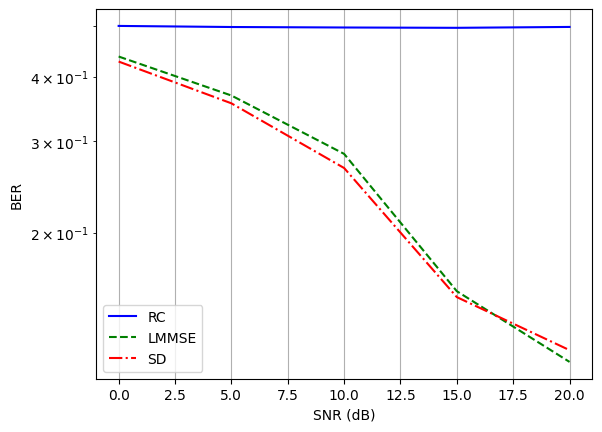

In [5]:
import numpy as np
from scipy.linalg import eigh
from sklearn.linear_model import Ridge
from itertools import product
import matplotlib.pyplot as plt

# Parameters
N_sc = 64
N_cp = 16
N_tx = 2
N_rx = 2
mod_order = 16  # 16-QAM as in paper
Q = 4
N_test = 100
num_trials = 3
window_size = 128
reservoir_size = 256
spectral_radius = 0.99
input_scale = 0.1
sparsity = 0.05
lambda_reg = 1e-2
P = 20
L = 3
washout = 50

# PA
rho = 3.0
x_sat = 1.0
ibo_db_linear = 10.0
ibo_db_nonlinear = 2.2

# Constellation for 16-QAM (normalized, Gray coded)
levels = np.array([-3, -1, 1, 3]) / np.sqrt(10)
constellation = np.array([a + 1j*b for a in levels for b in levels])
bit_map = {i: list(map(int, bin(i ^ (i // 2)) [2:].zfill(4))) for i in range(16)}  # Gray

# Symbols
def generate_symbols(N_symbols, N_tx, N_sc, mod_order):
    indices = np.random.randint(0, mod_order, size=(N_symbols, N_tx, N_sc))
    symbols_freq = constellation[indices]
    bits = np.array([bit_map[i] for i in indices.flatten()]).reshape(indices.shape + (4,))
    return symbols_freq, bits

# Modulate
def ofdm_modulate(symbols_freq, N_sc, N_cp):
    symbols_time = np.fft.ifft(symbols_freq, n=N_sc, axis=-1) * np.sqrt(N_sc)
    cp = symbols_time[..., -N_cp:]
    symbols_time_cp = np.concatenate([cp, symbols_time], axis=-1)
    return symbols_time_cp

# PA
def apply_pa(symbols_time_cp, rho, x_sat, ibo_db):
    ibo = 10 ** (ibo_db / 10.0)
    symbols_time_cp /= np.sqrt(np.mean(np.abs(symbols_time_cp)**2))
    symbols_time_cp /= np.sqrt(ibo)
    abs_x = np.abs(symbols_time_cp)
    gain = 1.0 / (1.0 + (abs_x / x_sat)**(2 * rho))**(1.0 / (2 * rho))
    return symbols_time_cp * gain

# Channel
def generate_channel(N_rx, N_tx):
    tap_length = 10
    k = np.arange(tap_length)
    powers = np.exp(-k / 5.0)
    powers /= np.sum(powers)
    h = np.zeros((N_rx, N_tx, tap_length), dtype=complex)
    for k in range(tap_length):
        h[:, :, k] = np.sqrt(powers[k] / 2) * (np.random.randn(N_rx, N_tx) + 1j * np.random.randn(N_rx, N_tx))
    return h

# Transmit
def transmit(symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db):
    if apply_nonlin:
        symbols_time_cp = apply_pa(symbols_time_cp, rho, x_sat, ibo_db)
    N_symbols, N_tx, N_time = symbols_time_cp.shape
    conv_length = N_time + h.shape[-1] - 1
    received = np.zeros((N_symbols, N_rx, conv_length), dtype=complex)
    for sym in range(N_symbols):
        for rx in range(N_rx):
            for tx in range(N_tx):
                received[sym, rx] += np.convolve(symbols_time_cp[sym, tx], h[rx, tx], mode='full')
    signal_power = np.mean(np.abs(received)**2)
    snr = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr if signal_power > 0 else 1.0 / snr
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*received.shape) + 1j * np.random.randn(*received.shape))
    received += noise
    return received, noise_power / signal_power

# Remove CP
def remove_cp(signal_cp, N_cp, N_sc):
    return signal_cp[..., N_cp : N_cp + N_sc]

# Real valued
def prepare_real_valued(data, N_ant):
    return np.hstack([data.real.reshape(-1, N_ant), data.imag.reshape(-1, N_ant)])

# Sliding window
def add_sliding_window(inputs, window_size):
    T, D = inputs.shape
    windowed = np.zeros((T, D * window_size))
    for t in range(T):
        start = max(0, t - window_size + 1)
        seg = inputs[start:t+1].flatten()
        windowed[t, -len(seg):] = seg
    return windowed

# TimeDomainRC
class TimeDomainRC:
    def __init__(self, input_dim, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg):
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.lambda_reg = lambda_reg
        self.W_in = input_scale * (2 * np.random.rand(reservoir_size, input_dim) - 1)
        self.W_r = self._generate_reservoir(sparsity, spectral_radius)
        self.W_out = None

    def _generate_reservoir(self, sparsity, spectral_radius):
        W_r = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        mask = np.random.rand(*W_r.shape) < sparsity
        W_r[~mask] = 0
        if np.any(W_r):
            eigenvalues = eigh(W_r, eigvals_only=True)
            W_r *= spectral_radius / np.max(np.abs(eigenvalues))
        return W_r

    def compute_states(self, inputs):
        T = inputs.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = np.tanh(self.W_r @ state + self.W_in @ inputs[t])
            states[t] = state
        return states

# Train single
def train_single_rc(train_input, train_target, P, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg, washout):
    rc = TimeDomainRC(train_input.shape[1], reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg)
    states = rc.compute_states(train_input)
    T = states.shape[0]
    min_error = float('inf')
    best_W_out = None
    best_p = 0
    for p in range(P + 1):
        if p + washout >= T: continue
        states_offset = states[washout : T - p] if p > 0 else states[washout : T]
        targets_offset = train_target[washout + p : T + p] if p > 0 else train_target[washout : T]
        if states_offset.shape[0] == 0 or states_offset.shape[0] != targets_offset.shape[0]: continue
        states_bias = np.hstack([np.ones((states_offset.shape[0], 1)), states_offset])
        ridge = Ridge(alpha=rc.lambda_reg, fit_intercept=False)
        ridge.fit(states_bias, targets_offset)
        preds = ridge.predict(states_bias)
        error = np.mean((preds - targets_offset)**2)
        if error < min_error:
            min_error = error
            best_W_out = ridge.coef_.T
            best_p = p
    rc.W_out = best_W_out
    return rc, best_p, min_error

# Predict single
def predict_single(rc, test_input, p):
    states = rc.compute_states(test_input)
    states_bias = np.hstack([np.ones((states.shape[0], 1)), states])
    predictions = states_bias @ rc.W_out
    if p > 0:
        pad = np.zeros((p, predictions.shape[1]))
        predictions = np.vstack([pad, predictions[:-p]])
    return predictions

# Train deep
def train_deep_rc(train_input, train_target, L, P, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg, washout):
    rcs = []
    ps = []
    errors = []
    current_target = train_target.copy()
    for l in range(L):
        rc, p, error = train_single_rc(train_input, current_target, P, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg, washout)
        rcs.append(rc)
        ps.append(p)
        errors.append(error)
        layer_pred = predict_single(rc, train_input, p)
        current_target -= layer_pred
    return rcs, ps, errors

# Predict deep
def predict_deep(rcs, ps, test_input):
    prediction = np.zeros((test_input.shape[0], rcs[0].W_out.shape[1]))
    for rc, p in zip(rcs, ps):
        prediction += predict_single(rc, test_input, p)
    return prediction

# Estimate CSI
def estimate_csi(train_received_no_cp, train_symbols_freq, N_sc):
    train_received_freq = np.fft.fft(train_received_no_cp, axis=-1)
    hat_H = np.zeros((N_rx, N_tx, N_sc), dtype=complex)
    for k in range(N_sc):
        S = train_symbols_freq[:, :, k].T
        Y = train_received_freq[:, :, k].T
        hat_H[:, :, k] = Y @ np.linalg.pinv(S)
    return hat_H

# LMMSE
def lmmse_detect(test_received_no_cp, hat_H, sigma2, N_sc):
    test_received_freq = np.fft.fft(test_received_no_cp, axis=-1)
    hat_s = np.zeros(test_received_freq.shape, dtype=complex)
    for sym in range(test_received_freq.shape[0]):
        for k in range(N_sc):
            H = hat_H[:, :, k]
            y = test_received_freq[sym, :, k]
            inv = np.linalg.inv(H.T.conj() @ H + sigma2 * np.eye(N_tx))
            W = inv @ H.T.conj()
            hat_s[sym, :, k] = W @ y
    return hat_s

# SD
def sd_detect(test_received_no_cp, hat_H, constellation, N_sc):
    test_received_freq = np.fft.fft(test_received_no_cp, axis=-1)
    hat_s = np.zeros(test_received_freq.shape, dtype=complex)
    combos = np.array(list(product(constellation, repeat=N_tx)))
    for sym in range(test_received_freq.shape[0]):
        for k in range(N_sc):
            H = hat_H[:, :, k]
            y = test_received_freq[sym, :, k]
            dists = np.sum(np.abs(y[:, np.newaxis] - H @ combos.T)**2, axis=0)
            min_idx = np.argmin(dists)
            hat_s[sym, :, k] = combos[min_idx]
    return hat_s

# Reconstruct
def reconstruct_complex(pred_real, N_tx, N_sc, N_symbols):
    real = pred_real[:, :N_tx].reshape(N_symbols, N_tx, N_sc)
    imag = pred_real[:, N_tx:].reshape(N_symbols, N_tx, N_sc)
    return real + 1j * imag

# Demod
def demod_to_bits(hat_s, constellation, bit_map):
    indices = np.argmin(np.abs(hat_s[..., None] - constellation), axis=-1)
    bits = np.array([bit_map[i] for i in indices.flatten()]).reshape(indices.shape + (4,))
    return bits

# BER
def compute_ber(pred_bits, target_bits):
    return np.mean(pred_bits != target_bits)

# Trial
def simulation_trial(snr_db, apply_nonlin, ibo_db):
    h = generate_channel(N_rx, N_tx)
    
    train_symbols_freq, train_bits = generate_symbols(Q, N_tx, N_sc, mod_order)
    train_symbols_time_cp = ofdm_modulate(train_symbols_freq, N_sc, N_cp)
    train_received, sigma2 = transmit(train_symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db)
    train_y_time = remove_cp(train_symbols_time_cp, N_cp, N_sc)
    train_received_no_cp = remove_cp(train_received, N_cp, N_sc)
    
    train_input = prepare_real_valued(train_received_no_cp, N_rx)
    train_target = prepare_real_valued(train_y_time, N_tx)
    mean_in = np.mean(train_input, axis=0)
    std_in = np.std(train_input, axis=0) +1e-8
    train_input = (train_input - mean_in) / std_in
    mean_tar = np.mean(train_target, axis=0)
    std_tar = np.std(train_target, axis=0) +1e-8
    train_target = (train_target - mean_tar) / std_tar
    train_input_window = add_sliding_window(train_input, window_size)
    
    rcs, ps, errors = train_deep_rc(train_input_window, train_target, L, P, reservoir_size, spectral_radius, input_scale, sparsity, lambda_reg, washout)
    
    hat_H = estimate_csi(train_received_no_cp, train_symbols_freq, N_sc)
    
    test_symbols_freq, test_bits = generate_symbols(N_test, N_tx, N_sc, mod_order)
    test_symbols_time_cp = ofdm_modulate(test_symbols_freq, N_sc, N_cp)
    test_received, _ = transmit(test_symbols_time_cp, h, snr_db, N_rx, apply_nonlin, ibo_db)
    test_y_time = remove_cp(test_symbols_time_cp, N_cp, N_sc)
    test_received_no_cp = remove_cp(test_received, N_cp, N_sc)
    
    test_input = prepare_real_valued(test_received_no_cp, N_rx)
    test_input = (test_input - mean_in) / std_in
    test_input_window = add_sliding_window(test_input, window_size)
    
    test_pred = predict_deep(rcs, ps, test_input_window)
    test_pred = test_pred * std_tar + mean_tar
    test_pred_complex = reconstruct_complex(test_pred, N_tx, N_sc, N_test)
    pred_freq = np.fft.fft(test_pred_complex, axis=-1)
    rc_bits = demod_to_bits(pred_freq, constellation, bit_map)
    ber_rc = compute_ber(rc_bits, test_bits)
    
    lmmse_hat_s = lmmse_detect(test_received_no_cp, hat_H, sigma2, N_sc)
    lmmse_bits = demod_to_bits(lmmse_hat_s, constellation, bit_map)
    ber_lmmse = compute_ber(lmmse_bits, test_bits)
    
    sd_hat_s = sd_detect(test_received_no_cp, hat_H, constellation, N_sc)
    sd_bits = demod_to_bits(sd_hat_s, constellation, bit_map)
    ber_sd = compute_ber(sd_bits, test_bits)
    
    return ber_rc, ber_lmmse, ber_sd

# Run
snr_range = np.arange(0, 25, 5)

for nonlin, ibo in [(False, ibo_db_linear), (True, ibo_db_nonlinear)]:
    print(f"{'Nonlinear' if nonlin else 'Linear'} PA")
    avg_ber_rc = []
    avg_ber_lmmse = []
    avg_ber_sd = []
    for snr_db in snr_range:
        bers_rc, bers_lmmse, bers_sd = [], [], []
        for _ in range(num_trials):
            br, bl, bs = simulation_trial(snr_db, nonlin, ibo)
            bers_rc.append(br)
            bers_lmmse.append(bl)
            bers_sd.append(bs)
        mean_rc = np.mean(bers_rc)
        mean_lmmse = np.mean(bers_lmmse)
        mean_sd = np.mean(bers_sd)
        print(f"SNR {snr_db} dB: RC {mean_rc:.4f}, LMMSE {mean_lmmse:.4f}, SD {mean_sd:.4f}")
        avg_ber_rc.append(mean_rc)
        avg_ber_lmmse.append(mean_lmmse)
        avg_ber_sd.append(mean_sd)

# Plot
plt.figure()
plt.semilogy(snr_range, avg_ber_rc, 'b-', label='RC')
plt.semilogy(snr_range, avg_ber_lmmse, 'g--', label='LMMSE')
plt.semilogy(snr_range, avg_ber_sd, 'r-.', label='SD')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.grid(True)
plt.show()